__File: quasideuteron.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     Jan 24, 2022__

Using method from SRC paper to analyze the quasideuteron model and the Levinger constant in connection to GCF papers.

__Revision history:<br/>__
* Jan 26, 2022 - Finished a function that verifies the asymptotic relation between the single-nucleon and pair momentum distributions at high momentum. The function also shows VMC calculations when possible. Also finished a function that plots the ratio of $n_{pn}^A(q)/n_p^d(q)$ relative to the Levinger constant.
* Feb 2, 2022 - Updating figure functions to save to figures/quasideuteron. So far, we can plot the ratio of pn/d momentum distributions, the Levinger constant with respect to A, print a table of Levinger constants, and look at the asymptotic relation between proton and pair momentum distributions. In all cases, we compare to experiment or AV18 VMC calculations when possible.
* Feb 9, 2022 - Updated momentum distributions data to include other phenomenological potentials. This notebook will now work for the following additional potentials: Paris, Bonn, Reid93, Nijmegen I, Nijmegen II, and CD-Bonn.
* Feb 14, 2022 - Checking that RKE N$^4$LO $550$ MeV can be roughly connected to RKE N$^4$LO $450$ MeV through SRG evolution. The subsequent $pn/d$ ratio then 

In [1]:
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
import numpy as np
# Scripts made by A.T.
from densities import load_density
from dmd import deuteron_momentum_distributions
from figures import figures_functions as ff
from misc.integration import gaussian_quadrature_mesh
from pmd import pair_momentum_distributions
from potentials.vsrg_macos import vnn
from snmd import single_nucleon_momentum_distributions
import time

# Set-up

In [2]:
def setup_rc_params(presentation=False):
    """
    Set matplotlib's rc parameters for the plots
    
    Parameters
    ----------
    presentation : bool, optional
        Option to enlarge font sizes for presentations.
    
    """

    if presentation:
        fontsize = 14
    else:
        fontsize = 9
    black = 'k'

    mpl.rcdefaults()  # Set to defaults

    mpl.rc('text', usetex=True)
    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams['font.family'] = 'serif'

#     mpl.rcParams['axes.labelsize'] = fontsize
    mpl.rcParams['axes.edgecolor'] = black
    # mpl.rcParams['axes.xmargin'] = 0
    mpl.rcParams['axes.labelcolor'] = black
#     mpl.rcParams['axes.titlesize'] = fontsize

    mpl.rcParams['ytick.direction'] = 'in'
    mpl.rcParams['xtick.direction'] = 'in'
    mpl.rcParams['xtick.labelsize'] = fontsize
    mpl.rcParams['ytick.labelsize'] = fontsize
    mpl.rcParams['xtick.color'] = black
    mpl.rcParams['ytick.color'] = black
    # Make the ticks thin enough to not be visible at the limits of the plot (over the axes border)
    mpl.rcParams['xtick.major.width'] = mpl.rcParams['axes.linewidth'] * 0.95
    mpl.rcParams['ytick.major.width'] = mpl.rcParams['axes.linewidth'] * 0.95
    # The minor ticks are little too small, make them both bigger.
    mpl.rcParams['xtick.minor.size'] = 2.4  # Default 2.0
    mpl.rcParams['ytick.minor.size'] = 2.4
    mpl.rcParams['xtick.major.size'] = 3.9  # Default 3.5
    mpl.rcParams['ytick.major.size'] = 3.9
    
    # Added by A.T.
    # Puts tick marks (not labels) on top and right axes
    mpl.rcParams['xtick.top'] = True
    mpl.rcParams['ytick.right'] = True
    
    ppi = 72  # points per inch
    # dpi = 150
#     mpl.rcParams['figure.titlesize'] = fontsize
    mpl.rcParams['figure.dpi'] = 150  # To show up reasonably in notebooks
    mpl.rcParams['figure.constrained_layout.use'] = False
    # 0.02 and 3 points are the defaults:
    # can be changed on a plot-by-plot basis using fig.set_constrained_layout_pads()
    mpl.rcParams['figure.constrained_layout.wspace'] = 0.0
    mpl.rcParams['figure.constrained_layout.hspace'] = 0.0
    mpl.rcParams['figure.constrained_layout.h_pad'] = 3. / ppi  # 3 points
    mpl.rcParams['figure.constrained_layout.w_pad'] = 3. / ppi

#     mpl.rcParams['legend.title_fontsize'] = fontsize
#     mpl.rcParams['legend.fontsize'] = fontsize
    mpl.rcParams['legend.edgecolor'] = 'inherit'  # inherits from axes.edgecolor, to match
    # Set facecolor with its own alpha, so edgecolor is unaffected
    mpl.rcParams['legend.fancybox'] = True
    mpl.rcParams['legend.facecolor'] = (1, 1, 1, 0.6)
#     mpl.rcParams['legend.borderaxespad'] = 0.8
    # Do not set overall alpha (affects edgecolor). Handled by facecolor above
    mpl.rcParams['legend.framealpha'] = None
    # This is for legend edgewidth, since it does not have its own option
    mpl.rcParams['patch.linewidth'] = 0.8
    mpl.rcParams['hatch.linewidth'] = 0.5

    # bbox = 'tight' can distort the figure size when saved (that's its purpose).
    # mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.04, dpi=350, format='png')
    # mpl.rc('savefig', transparent=False, bbox=None, dpi=400, format='png')
    mpl.rc('savefig', bbox='tight', dpi=400)

In [3]:
# Run this cell to customize matplotlib graphics
setup_rc_params(presentation=True)

In [4]:
# Save figures in the following directory
figure_directory = 'figures/quasideuteron'

# Load data from the following directories
exp_data_directory = 'data/exp' # Data from experiments
vmc_data_directory = 'data/vmc' # Momentum distributions from AV18 VMC

# Channels to include in calculations
channels = ['1S0', '3S1'] # S-waves only
channels_3s1 = ['3S1'] # 3S1-3D1 only
channels_pwaves = ['1S0', '3S1', '3P0', '1P1', '3P1']

# Specify which momentum mesh you want to use
kmax, kmid, ntot = 15.0, 3.0, 120

# Default SRG \lambda value
lamb = 1.35
lambdas = [2, 3, 6] # Higher \lambda values

# Nuclei to calculate using available EDF's
nuclei_sly4 = [
    ('He4', 2, 2), ('C12', 6, 6), ('O16', 8, 8), ('Ca40', 20, 20),
    ('Ca48', 20, 28), ('Fe56', 26, 30), ('Pb208', 82, 126)
]
nuclei_gogny = [
    ('He4', 2, 2), ('Be9', 4, 5), ('C12', 6, 6), ('O16', 8, 8),
    ('Al27', 13, 14), ('Ca40', 20, 20), ('Ca48', 20, 28), ('Fe56', 26, 30),
    ('Cu63', 29, 34), ('Au197', 79, 118), ('Pb208', 82, 126)
]

# Default EDF is SLy4
edf = 'SLY4'

# The Levinger constant

At high energy, the Levinger constant relates the photoabsorption cross sections of a nucleus to a deuteron. Experimental results suggest that the value is constant across the nuclear chart $L \approx 5.50 \pm 0.21$. In the GCF papers, they show that the Levinger constant can be related to the ratio of contacts. Furthermore, at high momentum

\begin{aligned}
\frac{ F_{pn}(A) }{ n_p(d) } \approx L \frac{NZ}{A},
\end{aligned}

where $F_{pn}(A)$ is the relative pair momentum distribution of nucleus $A$ (integrate out $Q$ dependence) and $n_p(d)$ is the proton momentum distribution in deuteron. They present a figure of this ratio and a table with the average value over the range $4$ to $5$ fm$^{-1}$ using VMC momentum distributions.

In our calculation,

\begin{aligned}
F_{pn}(A) \equiv 
    n_{pn}^A(q) \approx 
        |F_{\rm hi}(q)|^2 \int d^3Q \int d^3k |F_{\rm lo}(k)|^2
            \theta( k_F^{\tau} - |\frac{\mathbf{Q}}{2}+\mathbf{k}| )
            \theta( k_F^{\tau'} - |\frac{\mathbf{Q}}{2}-\mathbf{k}| ),
\end{aligned}

and

\begin{aligned}
n_{p}(d) \approx&
    \int d^3K \int d^3k
        \delta U(k, |\mathbf{q}-\frac{\mathbf{K}}{2}|) \delta U^{\dagger}(|\mathbf{q}-\frac{\mathbf{K}}{2}|,k)
            \theta( k_F - |\frac{\mathbf{K}}{2}+\mathbf{k}| )
            \theta( k_F - |\frac{\mathbf{K}}{2}-\mathbf{k}| ) \\
    \approx& |F_{\rm hi}(q)|^2 \int d^3K \int d^3k |F_{\rm lo}(k)|^2
            \theta( k_F - |\frac{\mathbf{K}}{2}+\mathbf{k}| )
            \theta( k_F - |\frac{\mathbf{K}}{2}-\mathbf{k}| ).
\end{aligned}

Therefore, the ratio is given by a mean-field quantity determined by integrals over the Heaviside step functions dependent on Fermi momenta. This is pretty much the same as the $a_2$ calculation.

In [5]:
def plot_levinger_ratio(nuclei, channels, kvnn, lamb, kmax=15.0, kmid=3.0,
                        ntot=120, edf='SLY4', xlim=(0.0, 5.0), ylim=(0, 25)):
    """
    Plot ratios of the proton-neutron pair momentum distribution over the
    deuteron momentum distribution as a function of relative momentum q [fm^-1]
    (where the C.o.M. momentum Q is integrated out). The Levinger constant L is
    indicated by plateaus at high relative momentum scaled by NZ/A.
    
    Parameters
    ----------
    nuclei : list
        List that contains the details for various nuclei formatted as a tuple:
            (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    channels : list
        Partial wave channels to include in the calculation
            (e.g., ['1S0', '3S1']).
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    edf : str, optional
        Name of EDF (e.g., 'SLY4').
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [unitless].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # Set relative momentum values over [0, 5] fm^-1
    q_min, q_max, q_step = 0.0, 5.0, 0.05
    q_array = np.arange(q_min, q_max + q_step, q_step)
    ntot_q = len(q_array)
    
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)
    
    # Set-up meshes corresponding to q_i and Q_j
    q_mesh, Q_mesh = np.meshgrid(q_array, Q_array, indexing='ij')
    
    # Set-up mesh for Q integration
    _, dQ_mesh = np.meshgrid(q_array, Q_array**2 * Q_weights, indexing='ij')
    factor = 4*np.pi/(2*np.pi)**3
    
    # Initialize deuteron momentum distribution class
    dmd = deuteron_momentum_distributions(kvnn, lamb, kmax, kmid, ntot,
                                          interp=True)
    
    # Get interpolated functions of deuteron momentum distribution
    # Take total only ignoring isolated I, \delta U, \delta U^2
    n_d_func, _, _, _ = dmd.n_lambda_interp()
    
    # Calculate deuteron momentum distribution
    n_d_array = n_d_func(q_array)
    
    # Initialize pair momentum distribution class
    pmd = pair_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot)
    

    # --- Loop over nuclei and calculate ratio --- #
    
    # Store ratios in dictionary with nucleus name as key
    d = {}
    for nucleus in nuclei:
        
        # Details of the nucleus
        nucleus_name = nucleus[0]
        Z = nucleus[1]
        N = nucleus[2]
        A = N+Z
    
        # Try using interpolated pair momentum distribution first
        try:
    
            n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N,
                                                     edf)

        # Need to generate files first
        except OSError:
    
            t0 = time.time()
            pmd.write_file(nucleus_name, 'pn', Z, N, edf)
            t1 = time.time()
            mins = (t1-t0)/60
            print(f'Done with {nucleus_name} after {mins:.5f} minutes.')
    
            # Now get interpolated version
            n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N,
                                                     edf)

        # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
        n_pn_array_2d = 2*n_pn_func.ev(q_mesh, Q_mesh) # Factor of 2 for pn+np

        # Integrate out Q dependence where
        # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
        n_pn_array = factor * np.sum(dQ_mesh * n_pn_array_2d, axis=-1)
    
        # Calculate ratio and store in dictionary
        ratio_array = A/(N*Z) * n_pn_array / n_d_array
        d[nucleus_name] = ratio_array

    # Set-up average value of L
    L_mean = 5.5
    L_sig = 0.21
    
    # Convert L +/- L_sigma to arrays for errorbands
    L_upper_array = np.ones(ntot_q) * (L_mean + L_sig)
    L_lower_array = np.ones(ntot_q) * (L_mean - L_sig)
    
    
    # --- Plot --- #
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = r'$\frac{A}{NZ} \frac{ n_{pn}^A(q) }{ n_{p}^d(q) }$'
    y_label_size = 16

    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)

    # Add Levinger constant to figure (L = 5.5 +/- 0.21)
    ax.axhline(y=L_mean, label='L', color='xkcd:black', linestyle='dotted')
    ax.fill_between(q_array, y1=L_lower_array, y2=L_upper_array,
                    color='xkcd:black', alpha=0.3)

    # Add ratios to plot
    for i, nucleus in enumerate(nuclei):
        
        # Name of nucleus (e.g., 'C12')
        nucleus_name = nucleus[0]
        ratio_array = d[nucleus_name]
        
        # Add nucleus to legend
        curve_label = ff.nuclei_label_conversion(nucleus_name)
        
        # Set color
        curve_color = ff.xkcd_colors(i+1) # Skip black
        
        ax.plot(q_array, ratio_array, label=curve_label, linewidth=curve_width,
                color=curve_color)
        
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    return f, ax

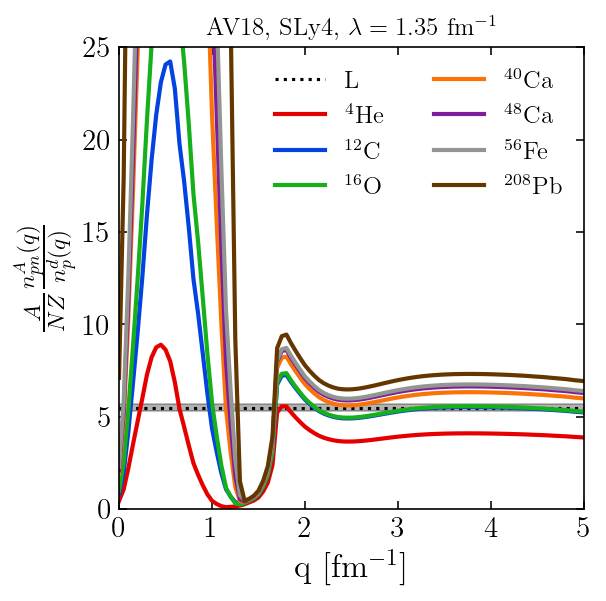

In [6]:
# AV18 with SLy4 and S-waves only (default)

kvnn = 6
f, ax = plot_levinger_ratio(nuclei_sly4, channels, kvnn, lamb, kmax, kmid,
                            ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = ff.kvnn_label_conversion(kvnn)
edf_label = 'SLy4'
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in nuclei_sly4:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_{kmax:.1f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [7]:
# # AV18 with SLy4 and only 3S1-3D1 channel

# kvnn = 6
# f, ax = plot_levinger_ratio(nuclei_sly4, channels_3s1, kvnn, lamb, kmax, kmid,
#                             ntot, edf)

# # Set legend
# legend_size = 12
# legend_location = 'upper right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# # Set title
# kvnn_label = ff.kvnn_label_conversion(kvnn)
# edf_label = 'SLy4'
# lambda_label = ff.lambda_label_conversion(lamb)
# title = f'{kvnn_label}, {edf_label}, {lambda_label}'
# title_size = 12
# ax.set_title(title, fontsize=title_size)

# # Set file name
# file_name = 'levinger_ratio'
# for inucleus in nuclei_sly4:
#     file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
# for ichannel in channels_3s1:
#     file_name += '_%s' % ichannel # (e.g., '1S0')
# file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_{kmax:.1f}_{edf}'
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# f.savefig(figure_directory + '/' + file_name)

In [8]:
# # AV18 with SLy4 and including some P-waves

# kvnn = 6
# f, ax = plot_levinger_ratio(nuclei_sly4, channels_pwaves, kvnn, lamb, kmax,
#                             kmid, ntot, edf)

# # Set legend
# legend_size = 12
# legend_location = 'upper right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# # Set title
# kvnn_label = ff.kvnn_label_conversion(kvnn)
# edf_label = 'SLy4'
# lambda_label = ff.lambda_label_conversion(lamb)
# title = f'{kvnn_label}, {edf_label}, {lambda_label}'
# title_size = 12
# ax.set_title(title, fontsize=title_size)

# # Set file name
# file_name = 'levinger_ratio'
# for inucleus in nuclei_sly4:
#     file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
# for ichannel in channels_pwaves:
#     file_name += '_%s' % ichannel # (e.g., '1S0')
# file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_{kmax:.1f}_{edf}'
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# f.savefig(figure_directory + '/' + file_name)

In [9]:
# # AV18 with SLy4 but \lambda = 2, 3, and 6 fm^-1

# kvnn = 6

# # Loop over higher \lambda values
# for i, ilamb in enumerate(lambdas):
    
#     f, ax = plot_levinger_ratio(nuclei_sly4, channels, kvnn, ilamb, kmax, kmid,
#                                 ntot, edf)

#     # Set legend
#     legend_size = 12
#     legend_location = 'upper right'
#     ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)
    
#     # Set title
#     kvnn_label = ff.kvnn_label_conversion(kvnn)
#     edf_label = 'SLy4'
#     lambda_label = ff.lambda_label_conversion(ilamb)
#     title = f'{kvnn_label}, {edf_label}, {lambda_label}'
#     title_size = 12
#     ax.set_title(title, fontsize=title_size)

#     # Set file name
#     file_name = 'levinger_ratio'
#     for inucleus in nuclei_sly4:
#         file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
#     for ichannel in channels:
#         file_name += '_%s' % ichannel # (e.g., '1S0')
#     file_name += f'_kvnn_{kvnn}_lamb_{ilamb:.2f}_kmax_{kmax:.1f}_{edf}'
#     file_name = ff.replace_periods(file_name) + '.png'

#     # Save figure
#     f.savefig(figure_directory + '/' + file_name)

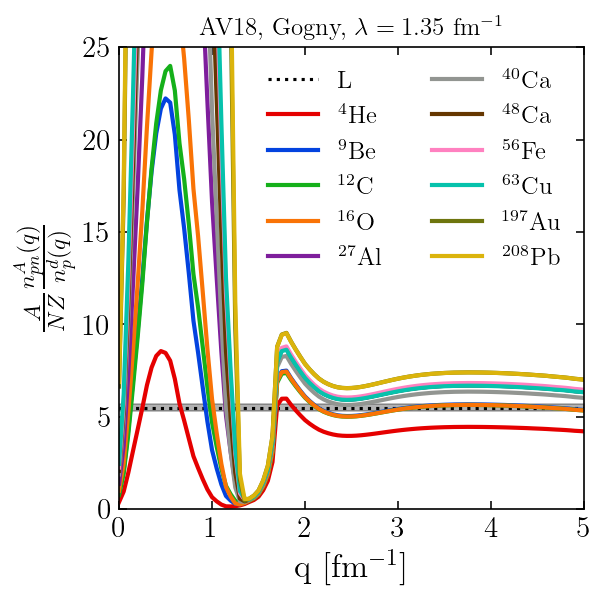

In [10]:
# AV18 with Gogny and S-waves only

kvnn = 6
f, ax = plot_levinger_ratio(nuclei_gogny, channels, kvnn, lamb, kmax, kmid,
                            ntot, 'Gogny')

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = ff.kvnn_label_conversion(kvnn)
edf_label = 'Gogny'
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in nuclei_gogny:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_{kmax:.1f}_Gogny'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

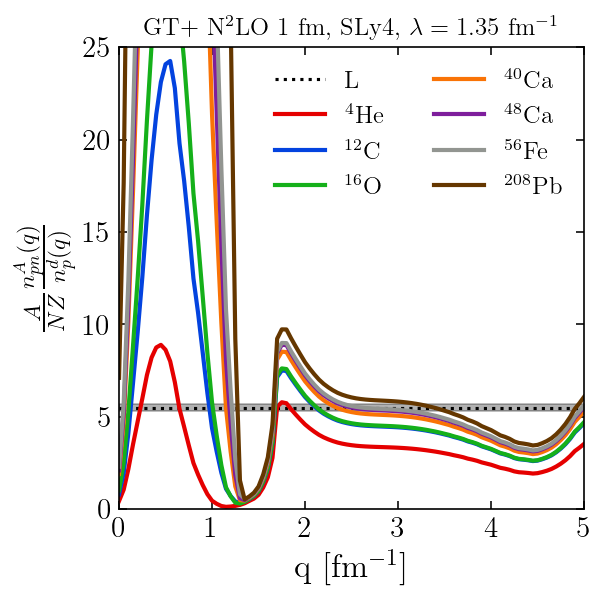

In [11]:
# Gezerlis N2LO 1 fm with SLy4 and S-waves only

kvnn = 222
f, ax = plot_levinger_ratio(nuclei_sly4, channels, kvnn, lamb, kmax, kmid,
                            ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = ff.kvnn_label_conversion(kvnn)
edf_label = 'SLy4'
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in nuclei_sly4:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_{kmax:.1f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

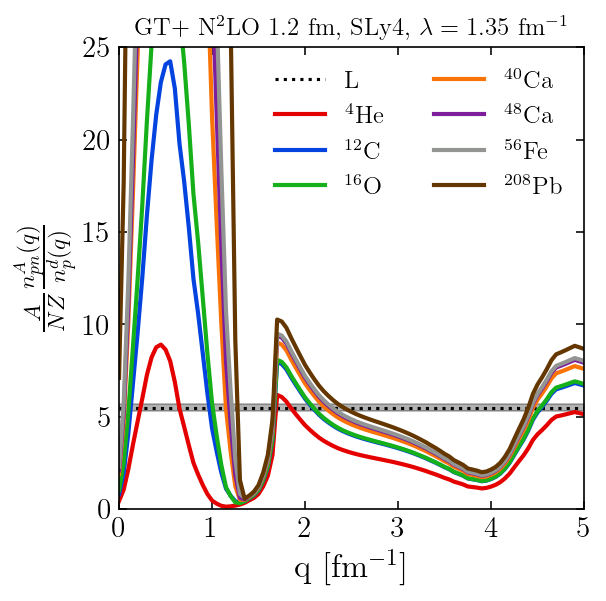

In [12]:
# Gezerlis N2LO 1.2 fm with SLy4 and S-waves only

kvnn = 224
f, ax = plot_levinger_ratio(nuclei_sly4, channels, kvnn, lamb, kmax, kmid,
                            ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = ff.kvnn_label_conversion(kvnn)
edf_label = 'SLy4'
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in nuclei_sly4:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_{kmax:.1f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

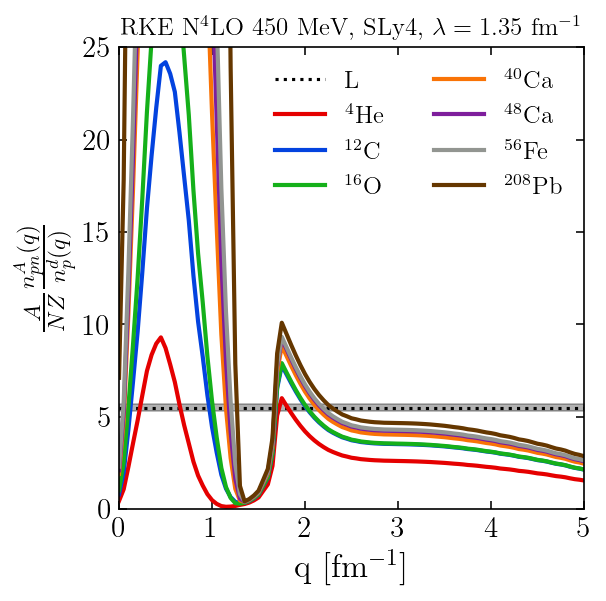

In [13]:
# RKE N4LO 450 MeV with SLy4 and S-waves only

kvnn = 111
f, ax = plot_levinger_ratio(nuclei_sly4, channels, kvnn, lamb, 10.0, 2.0,
                            ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = ff.kvnn_label_conversion(kvnn)
edf_label = 'SLy4'
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in nuclei_sly4:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_10.0_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

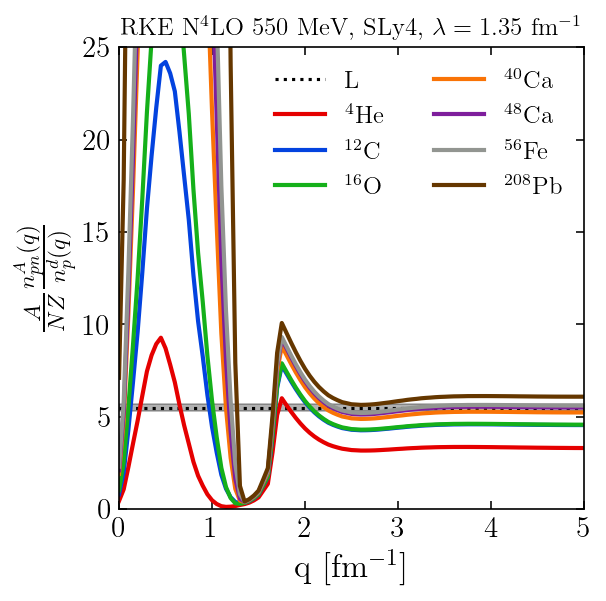

In [14]:
# RKE N4LO 550 MeV with SLy4 and S-waves only

kvnn = 113
f, ax = plot_levinger_ratio(nuclei_sly4, channels, kvnn, lamb, 10.0, 2.0,
                            ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = ff.kvnn_label_conversion(kvnn)
edf_label = 'SLy4'
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in nuclei_sly4:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_10.0_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

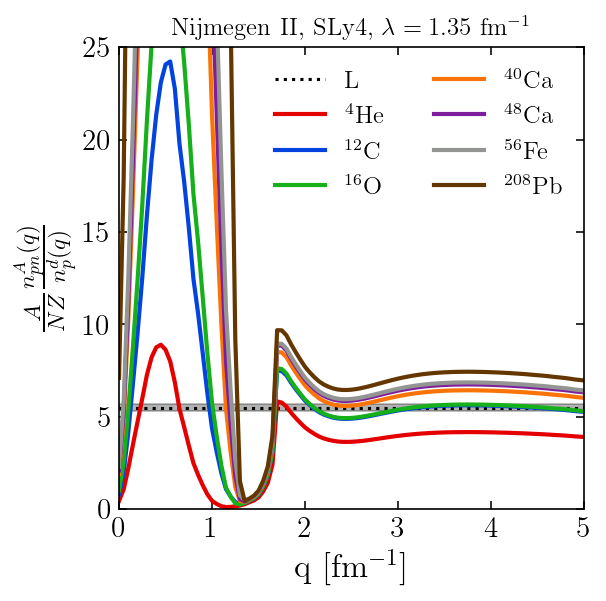

In [15]:
# Nijmegen II with SLy4 and S-waves only

kvnn = 5
f, ax = plot_levinger_ratio(nuclei_sly4, channels, kvnn, lamb, kmax, kmid,
                            ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = ff.kvnn_label_conversion(kvnn)
edf_label = 'SLy4'
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in nuclei_sly4:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_{kmax:.1f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

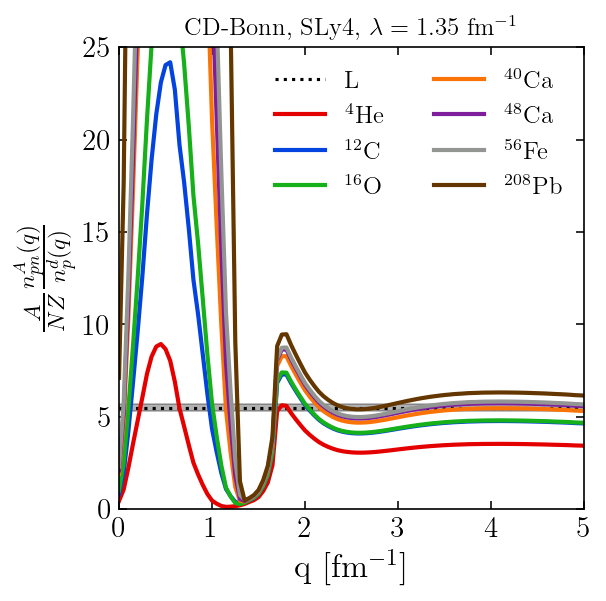

In [16]:
# CD-Bonn with SLy4 and S-waves only

kvnn = 7
f, ax = plot_levinger_ratio(nuclei_sly4, channels, kvnn, lamb, kmax, kmid,
                            ntot, edf)

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = ff.kvnn_label_conversion(kvnn)
edf_label = 'SLy4'
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_ratio'
for inucleus in nuclei_sly4:
    file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_{kmax:.1f}_{edf}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [17]:
# # EMN N4LO 500 MeV with SLy4 and S-waves only

# kvnn = 79
# f, ax = plot_levinger_ratio(nuclei_sly4, channels, kvnn, lamb, 10.0, 2.0,
#                             ntot, edf)

# # Set legend
# legend_size = 12
# legend_location = 'upper right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# # Set title
# kvnn_label = ff.kvnn_label_conversion(kvnn)
# edf_label = 'SLy4'
# lambda_label = ff.lambda_label_conversion(lamb)
# title = f'{kvnn_label}, {edf_label}, {lambda_label}'
# title_size = 12
# ax.set_title(title, fontsize=title_size)

# # Set file name
# file_name = 'levinger_ratio'
# for inucleus in nuclei_sly4:
#     file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
# for ichannel in channels:
#     file_name += '_%s' % ichannel # (e.g., '1S0')
# file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_10.0_{edf}'
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# f.savefig(figure_directory + '/' + file_name)

In [18]:
# # EM N3LO 500 MeV with SLy4 and S-waves only

# kvnn = 10
# f, ax = plot_levinger_ratio(nuclei_sly4, channels, kvnn, lamb, 10.0, 2.0,
#                             ntot, edf)

# # Set legend
# legend_size = 12
# legend_location = 'upper right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# # Set title
# kvnn_label = ff.kvnn_label_conversion(kvnn)
# edf_label = 'SLy4'
# lambda_label = ff.lambda_label_conversion(lamb)
# title = f'{kvnn_label}, {edf_label}, {lambda_label}'
# title_size = 14
# ax.set_title(title, fontsize=title_size)

# # Set file name
# file_name = 'levinger_ratio'
# for inucleus in nuclei_sly4:
#     file_name += '_%s' % inucleus[0] # Name of nucleus (e.g., 'C12')
# for ichannel in channels:
#     file_name += '_%s' % ichannel # (e.g., '1S0')
# file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_10.0_{edf}'
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# f.savefig(figure_directory + '/' + file_name)

In [19]:
def levinger_constant_table(q_range, nuclei, channels, kvnn, lamb, kmax=15.0,
                            kmid=3.0, ntot=120, edf='SLY4'):
    """
    Compute the average L value associated with the ratio of the proton-neutron
    pair momentum distribution over the deuteron momentum distribution as a
    function of relative momentum q [fm^-1] (where the C.o.M. momentum Q is
    integrated out). Here we average over some relative momentum range (as in
    Weiss et al., https://arxiv.org/pdf/1503.07047.pdf).
    
    Parameters
    ----------
    q_range : 1-D ndarray
        Array of momentum values to average L over [fm^-1].
    nuclei : list
        List that contains the details for various nuclei formatted as a tuple:
            (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    channels : list
        Partial wave channels to include in the calculation
            (e.g., ['1S0', '3S1']).
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    edf : str, optional
        Name of EDF (e.g., 'SLY4').

    """
    
    # --- Set-up --- #
    
    # Get number of q points
    ntot_q = len(q_range)
    
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)
    
    # Set-up meshes corresponding to q_i and Q_j
    q_mesh, Q_mesh = np.meshgrid(q_range, Q_array, indexing='ij')
    
    # Set-up mesh for Q integration
    _, dQ_mesh = np.meshgrid(q_range, Q_array**2 * Q_weights, indexing='ij')
    factor = 4*np.pi/(2*np.pi)**3
    
    # Initialize deuteron momentum distribution class
    dmd = deuteron_momentum_distributions(kvnn, lamb, kmax, kmid, ntot,
                                          interp=True)
    
    # Get interpolated functions of deuteron momentum distribution
    # Take total only and ignore the isolated terms
    n_d_func, _, _, _ = dmd.n_lambda_interp()
    
    # Calculate deuteron momentum distribution
    n_d_array = n_d_func(q_range)
    
    # Initialize pair momentum distribution class
    pmd = pair_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot)
    

    # --- Loop over nuclei and print --- #
    
    # Print header
    print('-'*79)
    print(f'Computing L for kvnn = {kvnn} and EDF = {edf}')
    print(
        f'Averaging over q from {min(q_range):.1f} to {max(q_range):.1f} fm^-1'
    )
    
    for nucleus in nuclei:
        
        # Details of the nucleus
        nucleus_name = nucleus[0]
        Z = nucleus[1]
        N = nucleus[2]
        A = N+Z
    
        # Try using interpolated pair momentum distribution first
        try:
    
            n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N,
                                                     edf)

        # Need to generate files first
        except OSError:
    
            t0 = time.time()
            pmd.write_file(nucleus_name, 'pn', Z, N, edf)
            t1 = time.time()
            mins = (t1-t0)/60
            print(f'Done with {nucleus_name} after {mins:.5f} minutes.')
    
            # Now get interpolated version
            n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N,
                                                     edf)

        # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
        n_pn_array_2d = 2*n_pn_func.ev(q_mesh, Q_mesh) # Factor of 2 for pn+np

        # Integrate out Q dependence where
        # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
        n_pn_array = factor * np.sum(dQ_mesh * n_pn_array_2d, axis=-1) 
    
        # Get mean value of ratio over momentum range and print results
        ratio_array = A/(N*Z) * n_pn_array / n_d_array
        L_avg = np.mean(ratio_array)
        
        print(f'Nucleus = {nucleus_name}, L = {L_avg:.2f}')

In [20]:
# AV18 with SLy4 and S-waves only (default)

kvnn = 6

# Set relative momentum values over [4, 5] fm^-1 as in Weiss paper
q_min, q_max, q_step = 4.0, 5.0, 0.1
q_range = np.arange(q_min, q_max + q_step, q_step)

levinger_constant_table(q_range, nuclei_sly4, channels, kvnn, lamb, kmax, kmid,
                        ntot, edf)

-------------------------------------------------------------------------------
Computing L for kvnn = 6 and EDF = SLY4
Averaging over q from 4.0 to 5.0 fm^-1
Nucleus = He4, L = 4.01
Nucleus = C12, L = 5.40
Nucleus = O16, L = 5.44
Nucleus = Ca40, L = 6.18
Nucleus = Ca48, L = 6.49
Nucleus = Fe56, L = 6.59
Nucleus = Pb208, L = 7.15


In [21]:
# AV18 with Gogny and S-waves only (default)

kvnn = 6

# Set relative momentum values over [4, 5] fm^-1 as in Weiss paper
q_min, q_max, q_step = 4.0, 5.0, 0.1
q_range = np.arange(q_min, q_max + q_step, q_step)

levinger_constant_table(q_range, nuclei_gogny, channels, kvnn, lamb, kmax,
                        kmid, ntot, 'Gogny')

-------------------------------------------------------------------------------
Computing L for kvnn = 6 and EDF = Gogny
Averaging over q from 4.0 to 5.0 fm^-1
Nucleus = He4, L = 4.35
Nucleus = Be9, L = 5.54
Nucleus = C12, L = 5.51
Nucleus = O16, L = 5.51
Nucleus = Al27, L = 6.55
Nucleus = Ca40, L = 6.21
Nucleus = Ca48, L = 6.54
Nucleus = Fe56, L = 6.67
Nucleus = Cu63, L = 6.53
Nucleus = Au197, L = 7.23
Nucleus = Pb208, L = 7.23


In [22]:
# AV18 with SLy4 and S-waves only
# Taking average over 2.6 to 3.3 fm^-1

kvnn = 6

# Set relative momentum values over lower momentum range
q_min, q_max, q_step = 2.6, 3.3, 0.05
q_range = np.arange(q_min, q_max + q_step, q_step)

levinger_constant_table(q_range, nuclei_sly4, channels, kvnn, lamb, kmax,
                        kmid, ntot, edf)

-------------------------------------------------------------------------------
Computing L for kvnn = 6 and EDF = SLY4
Averaging over q from 2.6 to 3.3 fm^-1
Nucleus = He4, L = 3.88
Nucleus = C12, L = 5.23
Nucleus = O16, L = 5.27
Nucleus = Ca40, L = 5.98
Nucleus = Ca48, L = 6.27
Nucleus = Fe56, L = 6.37
Nucleus = Pb208, L = 6.91


In [23]:
# Gezerlis N2LO 1 fm with SLy4 and S-waves only
# Taking average over 2.6 to 3.3 fm^-1

kvnn = 222

# Set relative momentum values over [4, 5] fm^-1 as in Weiss paper
q_min, q_max, q_step = 2.6, 3.3, 0.05
q_range = np.arange(q_min, q_max + q_step, q_step)

levinger_constant_table(q_range, nuclei_sly4, channels, kvnn, lamb, kmax,
                        kmid, ntot, edf)

-------------------------------------------------------------------------------
Computing L for kvnn = 222 and EDF = SLY4
Averaging over q from 2.6 to 3.3 fm^-1
Nucleus = He4, L = 3.32
Nucleus = C12, L = 4.43
Nucleus = O16, L = 4.47
Nucleus = Ca40, L = 5.05
Nucleus = Ca48, L = 5.29
Nucleus = Fe56, L = 5.37
Nucleus = Pb208, L = 5.82


In [24]:
# RKE N4LO 450 MeV with SLy4 and S-waves only
# Taking average over 2.6 to 3.3 fm^-1

kvnn = 111

# Set relative momentum values over lower momentum range
q_min, q_max, q_step = 2.6, 3.3, 0.05
q_range = np.arange(q_min, q_max + q_step, q_step)

levinger_constant_table(q_range, nuclei_sly4, channels, kvnn, lamb, 10.0, 2.0,
                        ntot, edf)

-------------------------------------------------------------------------------
Computing L for kvnn = 111 and EDF = SLY4
Averaging over q from 2.6 to 3.3 fm^-1
Nucleus = He4, L = 2.62
Nucleus = C12, L = 3.54
Nucleus = O16, L = 3.56
Nucleus = Ca40, L = 4.05
Nucleus = Ca48, L = 4.25
Nucleus = Fe56, L = 4.32
Nucleus = Pb208, L = 4.68


In [25]:
# RKE N4LO 550 MeV with SLy4 and S-waves only
# Taking average over 2.6 to 3.3 fm^-1

kvnn = 113

# Set relative momentum values over lower momentum range
q_min, q_max, q_step = 2.6, 3.3, 0.05
q_range = np.arange(q_min, q_max + q_step, q_step)

levinger_constant_table(q_range, nuclei_sly4, channels, kvnn, lamb, 10.0, 2.0,
                        ntot, edf)

-------------------------------------------------------------------------------
Computing L for kvnn = 113 and EDF = SLY4
Averaging over q from 2.6 to 3.3 fm^-1
Nucleus = He4, L = 3.25
Nucleus = C12, L = 4.39
Nucleus = O16, L = 4.42
Nucleus = Ca40, L = 5.03
Nucleus = Ca48, L = 5.28
Nucleus = Fe56, L = 5.37
Nucleus = Pb208, L = 5.82


In [26]:
# Nijmegen II with SLy4 and S-waves only

kvnn = 5

# Set relative momentum values over [4, 5] fm^-1 as in Weiss paper
q_min, q_max, q_step = 4.0, 5.0, 0.1
q_range = np.arange(q_min, q_max + q_step, q_step)

levinger_constant_table(q_range, nuclei_sly4, channels, kvnn, lamb, kmax,
                        kmid, ntot, edf)

-------------------------------------------------------------------------------
Computing L for kvnn = 5 and EDF = SLY4
Averaging over q from 4.0 to 5.0 fm^-1
Nucleus = He4, L = 4.06
Nucleus = C12, L = 5.46
Nucleus = O16, L = 5.51
Nucleus = Ca40, L = 6.25
Nucleus = Ca48, L = 6.56
Nucleus = Fe56, L = 6.66
Nucleus = Pb208, L = 7.23


In [27]:
# CD-Bonn with SLy4 and S-waves only

kvnn = 7

# Set relative momentum values over [4, 5] fm^-1 as in Weiss paper
q_min, q_max, q_step = 4.0, 5.0, 0.1
q_range = np.arange(q_min, q_max + q_step, q_step)

levinger_constant_table(q_range, nuclei_sly4, channels, kvnn, lamb, kmax,
                        kmid, ntot, edf)

-------------------------------------------------------------------------------
Computing L for kvnn = 7 and EDF = SLY4
Averaging over q from 4.0 to 5.0 fm^-1
Nucleus = He4, L = 3.50
Nucleus = C12, L = 4.73
Nucleus = O16, L = 4.76
Nucleus = Ca40, L = 5.41
Nucleus = Ca48, L = 5.68
Nucleus = Fe56, L = 5.77
Nucleus = Pb208, L = 6.26


In [28]:
def plot_levinger_constant(q_range, nuclei_sly4, nuclei_gogny, channels, kvnn,
                           lamb, kmax=15.0, kmid=3.0, ntot=120,
                           xlim=(5e0, 3e2), ylim=(0.0, 10.0)):
    """
    Plot the average Levinger constant values L associated with the ratio of
    pn/d momentum distributions with respect to mass number A. Compare to
    experimental data where available.
    
    Parameters
    ----------
    q_range : 1-D ndarray
        Array of momentum values to average L over [fm^-1].
    nuclei_sly4 : list
        List that contains the details for various nuclei corresponding to
        SLy4 formatted as a tuple:
            (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    nuclei_gogny : list
        List that contains the details for various nuclei corresponding to
        Gogny formatted as a tuple:
            (name (str), Z (int), N (int)) (e.g., nuclei[i] = ('O16', 8, 8)).
    channels : list
        Partial wave channels to include in the calculation
            (e.g., ['1S0', '3S1']).
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    edf : str, optional
        Name of EDF (e.g., 'SLY4').
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [unitless].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # Get number of q points
    ntot_q = len(q_range)
    
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)
    
    # Set-up meshes corresponding to q_i and Q_j
    q_mesh, Q_mesh = np.meshgrid(q_range, Q_array, indexing='ij')
    
    # Set-up mesh for Q integration
    _, dQ_mesh = np.meshgrid(q_range, Q_array**2 * Q_weights, indexing='ij')
    factor = 4*np.pi/(2*np.pi)**3
    
    # Initialize deuteron momentum distribution class
    dmd = deuteron_momentum_distributions(kvnn, lamb, kmax, kmid, ntot,
                                          interp=True)
    
    # Get interpolated functions of deuteron momentum distribution
    # Ignore the 1, \delta U, and \delta U^2 isolated contributions
    n_d_func, _, _, _ = dmd.n_lambda_interp()
    
    # Calculate deuteron momentum distribution
    n_d_array = n_d_func(q_range)
    
    # Initialize pair momentum distribution class
    pmd = pair_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot)
    
    # Loop over EDF's
    d = {}
    for edf in ['SLY4', 'Gogny']:
    
        if edf == 'SLY4':
            nuclei = nuclei_sly4
        elif edf == 'Gogny':
            nuclei = nuclei_gogny
            
        d[edf] = {}
        d[edf]['A_array'] = np.zeros( len(nuclei) )
        d[edf]['L_array'] = np.zeros( len(nuclei) )
            
        # --- Loop over nuclei and print --- #
        for i, nucleus in enumerate(nuclei):
        
            # Details of the nucleus
            nucleus_name = nucleus[0]
            Z = nucleus[1]
            N = nucleus[2]
            A = N+Z
            
            # Add A value to array
            d[edf]['A_array'][i] = A
    
            # Try using interpolated pair momentum distribution first
            try:
    
                n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z,
                                                         N, edf)

            # Need to generate files first
            except OSError:
    
                t0 = time.time()
                pmd.write_file(nucleus_name, 'pn', Z, N, edf)
                t1 = time.time()
                mins = (t1-t0)/60
                print(f'Done with {nucleus_name} after {mins:.5f} minutes.')
    
                # Now get interpolated version
                n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z,
                                                         N, edf)

            # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
            # Factor of 2 for pn+np
            n_pn_array_2d = 2*n_pn_func.ev(q_mesh, Q_mesh)

            # Integrate out Q dependence where
            # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
            n_pn_array = factor * np.sum(dQ_mesh * n_pn_array_2d, axis=-1)
    
            # Get mean value of ratio over 4-5 fm^-1 and print results
            ratio_array = A/(N*Z) * n_pn_array / n_d_array
            L_avg = np.mean(ratio_array)
            d[edf]['L_array'][i] = L_avg

    # Experimental values
    data_ahr = np.loadtxt(
        exp_data_directory + '/' + \
        'Ahrens_L_Li7_Be9_C12_O16_Al27_Ca40.txt'
        )
    A_ahr_array = data_ahr[:, 0]
    L_ahr_array = data_ahr[:, 1]
    L_errors_ahr_array = np.array([ data_ahr[:, 2], data_ahr[:, 3] ])
    
    data_sti = np.loadtxt(
        exp_data_directory + '/' + \
        'Stibunov_L_C12_Al27_Ti48_Cu63_Ag107_Sn118_Pb208.txt'
        )
    A_sti_array = data_sti[:, 0]
    L_sti_array = data_sti[:, 1]
    L_errors_sti_array = np.array([ data_sti[:, 2], data_sti[:, 3] ])
    
    data_lep = np.loadtxt(
        exp_data_directory + '/' + \
        'Lepretre_L_Sn118_Ce140_Ta181_Pb208_U238.txt'
        )
    A_lep_array = data_lep[:, 0]
    L_lep_array = data_lep[:, 1]
    L_errors_lep_array = np.array([ data_lep[:, 2], data_lep[:, 3] ])

    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'Mass number A'
    x_label_size = 16
    y_label = 'L'
    y_label_size = 16

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Set log-scale on x-axis
    ax.set_xscale('log')
    
    # Experimental values
    ax.errorbar(A_ahr_array, L_ahr_array, yerr=L_errors_ahr_array,
                color='xkcd:blue', marker='d', linestyle='', markersize=6,
                label='Ahrens')
    ax.errorbar(A_sti_array, L_sti_array, yerr=L_errors_sti_array,
                color='xkcd:green', marker='^', linestyle='', markersize=6,
                label='Stibunov')
    ax.errorbar(A_lep_array, L_lep_array, yerr=L_errors_lep_array,
                color='xkcd:purple', marker='v', linestyle='', markersize=6,
                label='Lepretre')

    # Plot all your values at the same time (same markers and color)
    # Offset A by a bit so you can compare results
    ax.plot(0.98*d['Gogny']['A_array'], d['Gogny']['L_array'],
            color='xkcd:red', marker='o', linestyle='', markersize=6,
            label='Gogny')
    ax.plot(1.02*d['SLY4']['A_array'], d['SLY4']['L_array'],
            color='xkcd:black', marker='s', linestyle='', markersize=6,
            label='SLy4')

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)

    return f, ax

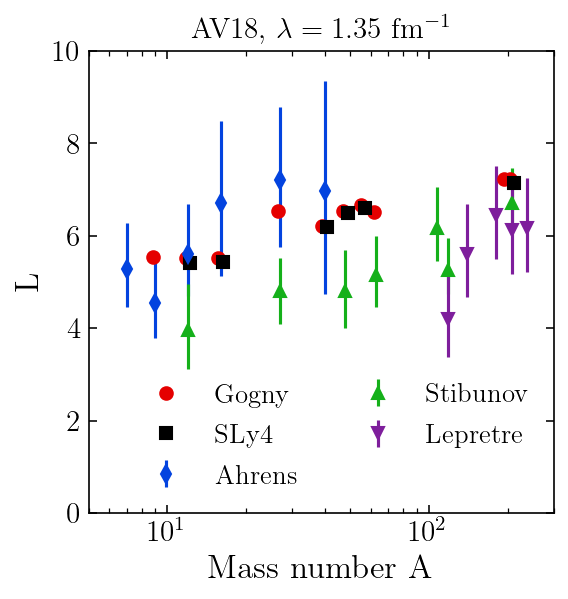

In [29]:
# Levinger values with error bars (SLy4 and Gogny with all experimental data)
# with AV18, S-waves only, and \lambda = 1.35 fm^-1

kvnn = 6

# Set relative momentum values over [4, 5] fm^-1 as in Weiss paper
q_min, q_max, q_step = 4.0, 5.0, 0.1
q_range = np.arange(q_min, q_max + q_step, q_step)

f, ax = plot_levinger_constant(q_range, nuclei_sly4, nuclei_gogny, channels,
                               kvnn, lamb, kmax, kmid, ntot)

# Add legend
legend_size = 13
legend_location = 'lower right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = ff.kvnn_label_conversion(kvnn)
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{kvnn_label}, {lambda_label}'
title_size = 14
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_constant'
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_{kmax:.1f}'
# Add q interval for averaging L to file name
file_name += f'_qmin_{q_min:.1f}_qmax_{q_max:.1f}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

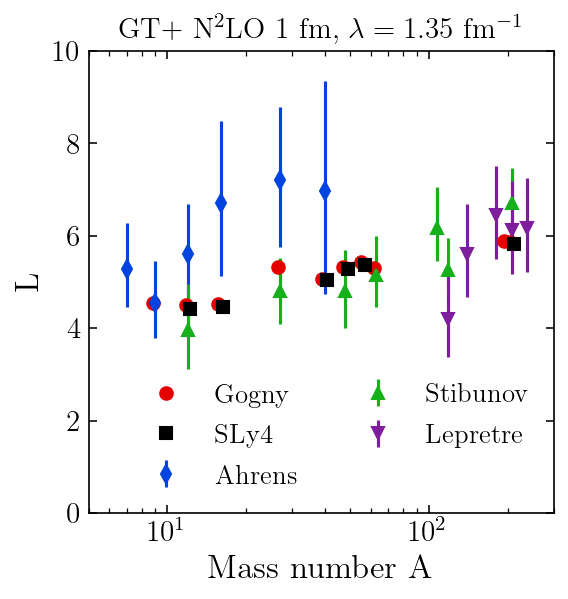

In [30]:
# Levinger values with error bars (SLy4 and Gogny with all experimental data)
# with Gezerlis N2LO 1 fm, S-waves only, and \lambda = 1.35 fm^-1

kvnn = 222

# Set relative momentum values over lower momentum range
q_min, q_max, q_step = 2.6, 3.3, 0.05
q_range = np.arange(q_min, q_max + q_step, q_step)

f, ax = plot_levinger_constant(q_range, nuclei_sly4, nuclei_gogny, channels,
                               kvnn, lamb, kmax, kmid, ntot)

# Add legend
legend_size = 13
legend_location = 'lower right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = ff.kvnn_label_conversion(kvnn)
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{kvnn_label}, {lambda_label}'
title_size = 14
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_constant'
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_{kmax:.1f}'
# Add q interval for averaging L to file name
file_name += f'_qmin_{q_min:.1f}_qmax_{q_max:.1f}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

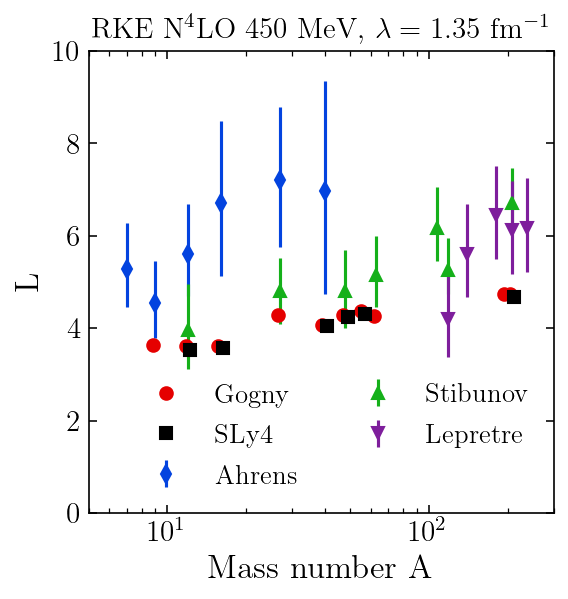

In [31]:
# Levinger values with error bars (SLy4 and Gogny with all experimental data)
# with RKE N4LO 450 MeV, S-waves only, and \lambda = 1.35 fm^-1

kvnn = 111

# Set relative momentum values over lower momentum range
q_min, q_max, q_step = 2.6, 3.3, 0.05
q_range = np.arange(q_min, q_max + q_step, q_step)

f, ax = plot_levinger_constant(q_range, nuclei_sly4, nuclei_gogny, channels,
                               kvnn, lamb, 10.0, 2.0, ntot)

# Add legend
legend_size = 13
legend_location = 'lower right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = ff.kvnn_label_conversion(kvnn)
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{kvnn_label}, {lambda_label}'
title_size = 14
ax.set_title(title, fontsize=title_size)

# Set file name
file_name = 'levinger_constant'
for ichannel in channels:
    file_name += '_%s' % ichannel # (e.g., '1S0')
file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}_kmax_10.0'
# Add q interval for averaging L to file name
file_name += f'_qmin_{q_min:.1f}_qmax_{q_max:.1f}'
file_name = ff.replace_periods(file_name) + '.png'

# Save figure
f.savefig(figure_directory + '/' + file_name)

In [32]:
# We still need Li7, Ti48, Ag107, Sn118, Ce140, Ta181, U238 to compare to all
# available experimental points

# Asymptotic relation of pair and single-nucleon momentum distributions:
\begin{aligned}
n_p(q) = 2F_{pp}(q)+F_{pn}(k)
\end{aligned}

In [33]:
def verify_asymptotic_relation(nucleus, channels, kvnn, lamb, kmax=15.0,
                               kmid=3.0, ntot=120, edf='SLY4',
                               normalizations=False, xlim=(0.0, 5.0),
                               ylim=(1e-3, 5e4)):
    """
    Check the asymptotic relation between the single-nucleon and pair momentum
    distributions. Compare to VMC calculations when possible.
    
    Parameters
    ----------
    nucleus : tuple
        Details for various nuclei formatted as a tuple:
            (name (str), Z (int), N (int)) (e.g., ('O16', 8, 8)).
    channels : tuple
        Partial wave channels to include in the calculation (e.g.,
        ('1S0', '3S1')).
    kvnn : int
        This number specifies the potential.
    lamb : float
        SRG \lambda parameter [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    edf : str, optional
        Name of EDF (e.g., 'SLY4').
    normalizations : bool, optional
        Option to print out normalizations of momentum distributions.
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [fm^3].
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # --- Low RG resolution calculation --- # 
    
    # Details of the nucleus
    nucleus_name = nucleus[0]
    Z = nucleus[1]
    N = nucleus[2]
    
    # Initialize single momentum distribution class
    snmd = single_nucleon_momentum_distributions(kvnn, channels, lamb, kmax,
                                                 kmid, ntot)

    # Try using interpolated versions first
    try:
    
        n_p_func, _, _, _ = snmd.n_lambda_interp(nucleus_name, 'proton', Z, N)

    # Need to generate files first
    except OSError:
    
        t0 = time.time()
        snmd.write_file(nucleus_name, 'proton', Z, N, edf)
        t1 = time.time()
        mins = (t1-t0)/60
        print(f'Done after {mins:.5f} minutes.')
    
        # Now get interpolated versions
        n_p_func, _, _, _ = snmd.n_lambda_interp(nucleus_name, 'proton', Z, N)
    
    # Initialize pair momentum distribution class
    pmd = pair_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot)

    # Try using interpolated versions first
    try:
    
        n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N, edf)
        n_pp_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pp', Z, N, edf)

    # Need to generate files first
    except OSError:
    
        t0 = time.time()
        pmd.write_file(nucleus_name, 'pn', Z, N, edf)
        pmd.write_file(nucleus_name, 'pp', Z, N, edf)
        t1 = time.time()
        mins = (t1-t0)/60
        print(f'Done after {mins:.5f} minutes.')
    
        # Now get interpolated versions
        n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N, edf)
        n_pp_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pp', Z, N, edf)
    
    # Set relative momentum values
    q_array, q_weights = vnn.load_momentum(kvnn, '1S0', kmax, kmid, ntot)
    
    # Calculate proton momentum distribution
    n_p_array = n_p_func(q_array)
    
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)

    # Set-up meshes corresponding to q_i and Q_j
    q_mesh, Q_mesh = np.meshgrid(q_array, Q_array, indexing='ij')

    # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
    n_pn_array_2d = 2*n_pn_func.ev(q_mesh, Q_mesh) # Factor of 2 for pn+np
    n_pp_array_2d = n_pp_func.ev(q_mesh, Q_mesh)

    # Set-up mesh for Q integration
    _, dQ_mesh = np.meshgrid(q_array, Q_array**2 * Q_weights, indexing='ij')
    factor = 4*np.pi/(2*np.pi)**3

    # Integrate out Q dependence where
    # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
    n_pn_array = factor * np.sum(dQ_mesh * n_pn_array_2d, axis=-1)
    n_pp_array = factor * np.sum(dQ_mesh * n_pp_array_2d, axis=-1)
    
    # Check normalizations?
    if normalizations:
        
        # Proton momentum distribution normalization
        p_norm = factor * np.sum(q_weights * q_array**2 * n_p_array)
        print(f'Proton distribution normalization = {p_norm:.5f}.')
        
        # Proton-neutron pair momentum distribution normalization
        pn_norm = factor * np.sum(q_weights * q_array**2 * n_pn_array)
        print(f'Proton-neutron distribution normalization = {pn_norm:.5f}.')
        
        # Proton-proton pair momentum distribution normalization
        pp_norm = factor * np.sum(q_weights * q_array**2 * n_pp_array)
        print(f'Proton-proton distribution normalization = {pp_norm:.5f}.')
        
        
    # --- Set-up figure --- #
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = r'$n_{\lambda}^A(q)$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 16
    
    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)

    # Set y-axis to log scale
    ax.set_yscale('log')
    
    # Add curves to figure
    ax.plot(q_array, n_p_array, color='xkcd:red', label=r'$n_p(q)$',
            linewidth=curve_width)
    ax.plot(q_array, 2*n_pp_array + n_pn_array, color='xkcd:blue',
            label=r'$2n_{pp}(q) + n_{np}(q)$', linewidth=curve_width)
    
    
    # --- Add in VMC data wherever possible --- #
    if nucleus_name in ['He4', 'He8', 'Be9', 'C12']:
        
        # Proton distribution
        vmc_snmd_data = np.loadtxt(
            vmc_data_directory + f'/AV18_{nucleus_name}_snmd.txt'
            )
        if nucleus == 'Be9':
            q_array_p_vmc = vmc_snmd_data[:, 0]
            n_p_array_vmc = vmc_snmd_data[:, 3]
            error_bars_array_vmc = vmc_snmd_data[:, 4]
        else:
            q_array_p_vmc = vmc_snmd_data[:, 0]
            n_p_array_vmc = vmc_snmd_data[:, 1]
            error_bars_array_vmc = vmc_snmd_data[:, 2]
            
        # Pair
        vmc_pmd_data = np.loadtxt(
            vmc_data_directory + f'/AV18_{nucleus_name}_pmd_q.txt'
            )
        q_array_NN_vmc = vmc_pmd_data[:, 0] # fm^-1
        if nucleus == 'He8' or nucleus == 'Be9':
            n_pn_array_vmc = vmc_pmd_data[:, 3]
            pn_error_bars_array_vmc = vmc_pmd_data[:, 4]
            n_pp_array_vmc = vmc_pmd_data[:, 5]
            pp_error_bars_array_vmc = vmc_pmd_data[:, 6]
        else:
            n_pn_array_vmc = vmc_pmd_data[:, 1]
            pn_error_bars_array_vmc = vmc_pmd_data[:, 2]
            n_pp_array_vmc = vmc_pmd_data[:, 3]
            pp_error_bars_array_vmc = vmc_pmd_data[:, 4]
        
        # Plot VMC data with error bars
        ax.plot(q_array_p_vmc, n_p_array_vmc, color='xkcd:red',
                label='VMC proton', linestyle='', marker='.')
        ax.plot(q_array_NN_vmc, 2*n_pp_array_vmc + n_pn_array_vmc,
                color='xkcd:blue', label='VMC pair', linestyle='', marker='.')
        
        # Check VMC normalizations?
        if normalizations:
            
            # Proton momentum distribution normalization
            p_vmc_norm = factor * np.sum(
                0.1 * q_array_p_vmc**2 * n_p_array_vmc
                )
            print(
                f'VMC proton distribution normalization = {p_vmc_norm:.5f}.'
                )
        
            # Proton-neutron pair momentum distribution normalization
            pn_vmc_norm = factor * np.sum(
                0.1 * q_array_NN_vmc**2 * n_pn_array_vmc
                )
            print(
                f'VMC pn distribution normalization = {pn_vmc_norm:.5f}.'
                )
        
            # Proton-proton pair momentum distribution normalization
            pp_vmc_norm = factor * np.sum(
                0.1 * q_array_NN_vmc**2 * n_pp_array_vmc
                )
            print(
                f'VMC pp distribution normalization = {pp_vmc_norm:.5f}.'
                )
        
        
    # --- Finish figure --- #

    # Shade gray from 0 to \lambda value on plot
    ax.fill_betweenx(ylim, 0.0, lamb, edgecolor='xkcd:grey',
                     facecolor='xkcd:grey', alpha=0.3)

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    return f, ax

In [34]:
# # C12 (and check normalizations)

# nucleus = ('C12', 6, 6)
# kvnn = 6

# f, ax = verify_asymptotic_relation(nucleus, channels, kvnn, lamb,
#                                    normalizations=True)

# # Add legend
# legend_size = 13
# legend_location = 'upper right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add nucleus label
# label = ff.nuclei_label_conversion(nucleus[0])
# label_location = 'lower left'
# label_size = 18
# anchored_text = AnchoredText(label, loc=label_location,
#                              prop=dict(size=label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = f'asymptotic_relation_{nucleus[0]}'
# for ichannel in channels:
#     file_name += '_%s' % ichannel # (e.g., '1S0')
# file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}'
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# f.savefig(figure_directory + '/' + file_name)

In [35]:
# # He4

# nucleus = ('He4', 2, 2)
# kvnn = 6
# ylim = (1e-3, 3e4)

# f, ax = verify_asymptotic_relation(nucleus, channels, kvnn, lamb, ylim=ylim)

# # Add legend
# legend_size = 13
# legend_location = 'upper right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add nucleus label
# label = ff.nuclei_label_conversion(nucleus[0])
# label_location = 'lower left'
# label_size = 18
# anchored_text = AnchoredText(label, loc=label_location,
#                              prop=dict(size=label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = f'asymptotic_relation_{nucleus[0]}'
# for ichannel in channels:
#     file_name += '_%s' % ichannel # (e.g., '1S0')
# file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}'
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# f.savefig(figure_directory + '/' + file_name)

In [36]:
# # Ca48

# nucleus = ('Ca48', 20, 28)
# kvnn = 6
# ylim = (1e-2, 1e5)

# f, ax = verify_asymptotic_relation(nucleus, channels, kvnn, lamb, ylim=ylim)

# # Add legend
# legend_size = 13
# legend_location = 'upper right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add nucleus label
# label = ff.nuclei_label_conversion(nucleus[0])
# label_location = 'lower left'
# label_size = 18
# anchored_text = AnchoredText(label, loc=label_location,
#                              prop=dict(size=label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = f'asymptotic_relation_{nucleus[0]}'
# for ichannel in channels:
#     file_name += '_%s' % ichannel # (e.g., '1S0')
# file_name += f'_kvnn_{kvnn}_lamb_{lamb:.2f}'
# file_name = ff.replace_periods(file_name) + '.png'

# # Save figure
# f.savefig(figure_directory + '/' + file_name)

# Extras

In [37]:
def plot_momentum_dist(nucleus, channels, kvnn, lamb, kmax=15.0, kmid=3.0,
                       ntot=120, edf='SLY4', xlim=(0.0, 5.0),
                       ylim=(1e-3, 1e3)):
    '''Compare deuteron and pn pair momentum distributions given a nucleus.'''
    
    
    # --- Low RG resolution calculation --- #
    
    # Details of the nucleus
    nucleus_name = nucleus[0]
    Z = nucleus[1]
    N = nucleus[2]
    A = N+Z
    
    # Set relative momentum values
    q_min, q_max, q_step = 0.05, 6.0, 0.05
    q_array = np.arange(q_min, q_max + q_step, q_step)
    ntot_q = len(q_array)
    
    # Initialize deuteron momentum distribution class
    dmd = deuteron_momentum_distributions(kvnn, lamb, kmax, kmid, ntot,
                                          interp=True)
    
    # Get interpolated functions of deuteron momentum distribution
    # Ignore the 1, \delta U, and \delta U^2 isolated contributions
    n_d_func, _, _, _ = dmd.n_lambda_interp()
    
    # Calculate deuteron momentum distribution
    n_d_array = n_d_func(q_array)
    
    # Initialize pair momentum distribution class
    pmd = pair_momentum_distributions(kvnn, channels, lamb, kmax, kmid, ntot)

    # Try using interpolated version first
    try:
    
        n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N, edf)

    # Need to generate files first
    except OSError:
    
        t0 = time.time()
        pmd.write_file(nucleus_name, 'pn', Z, N, edf)
        t1 = time.time()
        mins = (t1-t0)/60
        print(f'Done after {mins:.5f} minutes.')
    
        # Now get interpolated version
        n_pn_func, _, _, _ = pmd.n_lambda_interp(nucleus_name, 'pn', Z, N, edf)
        
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)

    # Set-up meshes corresponding to q_i and Q_j
    q_mesh, Q_mesh = np.meshgrid(q_array, Q_array, indexing='ij')

    # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
    n_pn_array_2d = 2*n_pn_func.ev(q_mesh, Q_mesh) # Factor of two for pn+np

    # Set-up mesh for Q integration
    _, dQ_mesh = np.meshgrid(q_array, Q_array**2 * Q_weights, indexing='ij')
    factor = 4*np.pi/(2*np.pi)**3

    # Integrate out Q dependence where
    # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
    n_pn_array = factor * np.sum(dQ_mesh * n_pn_array_2d, axis=-1)
    
    
    # --- Plot --- #
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = 'n(q) [fm' + r'$^3$' + ']'
    y_label_size = 16

    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Set y-axis to log scale
    ax.set_yscale('log')

    # Plot ratio with respect to momentum
    ax.plot(q_array, n_d_array, label='d', linewidth=curve_width,
            color='xkcd:black')
    ax.plot(q_array, n_pn_array, label='pn', linewidth=curve_width,
            color='xkcd:blue')
        
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)

    # Set legend
    legend_size = 14
    legend_location = 'upper right'
    ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

    # Add nucleus label
    label = ff.nuclei_label_conversion(nucleus_name)
    label_location = 'lower left'
    label_size = 18
    anchored_text = AnchoredText(label, loc=label_location,
                                 prop=dict(size=label_size), frameon=False)
    ax.add_artist(anchored_text);

In [38]:
# # AV18 C12
# kvnn = 6
# plot_momentum_dist(
#     ('C12', 6, 6), channels, kvnn, lamb, xlim=(0, 6), ylim=(1e-5, 1e3)
# )

In [39]:
# # Gezerlis N2LO 1 fm, C12
# kvnn = 222
# plot_momentum_dist(
#     ('C12', 6, 6), channels, 222, lamb, kmax, kmid, ntot, edf, 
#     xlim=(0.0, 6.0), ylim=(1e-5, 1e3)
# )

In [40]:
# # EM N3LO 500 MeV, C12
# kvnn = 10
# plot_momentum_dist(
#     ('C12', 6, 6), channels, 10, lamb, 10.0, 2.0, ntot, edf, 
#     xlim=(0.0, 6.0), ylim=(1e-7, 1e3)
# )

In [41]:
# # This cell verifies that the HF+LDA deuteron momentum distribution
# # roughly matches the actual result using the eigenvector from the
# # EM N3LO 500 MeV Hamiltonian
# from observables import wave_function

# kvnn = 10
# H_matrix = vnn.load_hamiltonian(kvnn, '3S1', 10.0, 2.0, ntot)
# psi_unitless = wave_function(H_matrix)

# k_array, k_weights = vnn.load_momentum(kvnn, '3S1', 10.0, 2.0, ntot)
# factor_array = 2/np.pi * k_array**2 * k_weights * ( 4*np.pi/(2*np.pi)**3 )

# n_d_array = (psi_unitless[:ntot]**2 + psi_unitless[ntot:]**2) / factor_array

# plt.semilogy(k_array, n_d_array)
# plt.xlabel(r'$k$' + ' fm' + r'$^{-1}$')
# plt.ylabel(r'$n_d(k)$' + ' fm' + r'$^{3}$')
# plt.xlim( (0, 6) )
# plt.ylim( (1e-7, 1e3) )
# plt.show()

In [42]:
# # RKE N4LO 450 MeV C12
# kvnn = 111
# plot_momentum_dist(
#     ('C12', 6, 6), channels, kvnn, lamb, kmax=10.0, kmid=2.0, xlim=(0, 6),
#     ylim=(1e-5, 1e3)
# )

In [43]:
# # RKE N4LO 550 MeV C12
# kvnn = 113
# plot_momentum_dist(
#     ('C12', 6, 6), channels, kvnn, lamb, kmax=10.0, kmid=2.0, xlim=(0, 6),
#     ylim=(1e-5, 1e3)
# )

In [44]:
from scipy.interpolate import interp1d, RectBivariateSpline
from misc.fourier_transform import hankel_transformation_k2r
from numpy.polynomial.legendre import leggauss

In [45]:
# Test version of dmd.py
class dmd_test(object):
    
    
    def __init__(self, kvnn, lamb_init, lamb_final, kmax, kmid, ntot,
                 interp=False):
        
        # Get relevant info for file and directory names
        # Part of data directory name
        self.kvnn = kvnn 
        # Part of file name
        self.lamb = lamb
        self.kmax = kmax
        
        # Set-up for calculation
        if interp == False:
            
            # Channel is 3S1-3D1 for deuteron
            channel = '3S1'

            # Load and save momentum arrays
            k_array, k_weights = vnn.load_momentum(kvnn, channel, kmax, kmid,
                                                   ntot)
            # Save k_array, k_weights, ntot
            self.k_array, self.k_weights, self.ntot = k_array, k_weights, ntot
            
            # For dividing out momenta/weights
            factor_array = np.sqrt( (2*k_weights) / np.pi ) * k_array
            # For coupled-channel matrices
            factor_array_cc = np.concatenate( (factor_array, factor_array) )

            # Load SRG transformation
            H_initial = vnn.load_hamiltonian(kvnn, channel, kmax, kmid, ntot,
                                             method='srg', generator='Wegner',
                                             lamb=lamb_init)
            H_evolved = vnn.load_hamiltonian(kvnn, channel, kmax, kmid, ntot,
                                             method='srg', generator='Wegner',
                                             lamb=lamb_final)
            # Load U(k, k') [unitless]
            U_matrix_unitless = SRG_unitary_transformation(H_initial, 
                                                           H_evolved)
            
            # Unitless wave function in momentum space
            psi_k_unitless = ob.wave_function(H_initial, U=U_matrix_unitless)
            self.psi = psi_k_unitless
            # Divide out momenta/weights and save
            self.psi_k = psi_k_unitless / factor_array_cc # [fm^3/2]

            # Isolate 2-body term and convert to fm^3
            I_matrix_unitless = np.eye( 2*ntot, 2*ntot )
            row, col = np.meshgrid(factor_array_cc, factor_array_cc)
            delta_U_matrix_unitless = U_matrix_unitless - I_matrix_unitless
            # Save for exact unitary calculation
            self.delta_U_matrix = delta_U_matrix_unitless
            delta_U_matrix = delta_U_matrix_unitless / row / col # fm^3
            
            # No 2*J+1 factor since we're fixing M_J for deuteron
            
            # Evaluate matrix elements
            deltaU = 1/2 * ( delta_U_matrix[:ntot, :ntot] + \
                             delta_U_matrix[ntot:, ntot:] )
            deltaU2 = 1/2 * ( delta_U_matrix[:ntot, :ntot]**2 + \
                              delta_U_matrix[:ntot, ntot:]**2 + \
                              delta_U_matrix[ntot:, :ntot]**2 + \
                              delta_U_matrix[ntot:, ntot:]**2 )

            # Interpolate < k | \delta U | k >
            self.deltaU_func = interp1d( k_array, np.diag(deltaU),
                                         kind='linear', bounds_error=False,
                                         fill_value='extrapolate' )

            # Interpolate < k | \delta U \delta U^{\dagger} | k' >
            self.deltaU2_func = RectBivariateSpline(k_array, k_array, deltaU2,
                                                    kx=1, ky=1)


    def theta_I(self, q_mesh, kF_mesh):
        """
        Evaluates \theta( kF(R) - q ). This function appears in the I term.

        Parameters
        ----------
        q_mesh : 2-D ndarray
            Momentum values [fm^-1].
        kF_mesh : 2-D ndarray
            Deuteron Fermi momentum [fm^-1] with respect to R.

        Returns
        -------
        theta_mesh : 2-D ndarray
            \theta function [unitless] evaluated for each q and kF(R).

        """
        
        # Initialize 2-D array
        theta_mesh = np.zeros( (self.ntot_q, self.ntot_R) )
        
        # Gives 1 if q < kF(R)
        theta_mesh[ q_mesh < kF_mesh ] = 1
        
        # This is a (ntot_q, ntot_R) size array
        return theta_mesh
        

    def theta_deltaU(self, q_mesh, kF_mesh, k_mesh):
        """
        Evaluates angle-average of \theta( kF(R) - \abs(q - 2k) ). This
        function appears in the \delta U term.

        Parameters
        ----------
        q_mesh : 3-D ndarray
            Momentum values [fm^-1].
        kF_mesh : 3-D ndarray
            Deuteron Fermi momentum [fm^-1] with respect to R.
        k_mesh : 3-D ndarray
            Relative momentum values [fm^-1].

        Returns
        -------
        theta_mesh : 3-D ndarray
            \theta function [unitless] evaluated for each q, kF(R), and k.
            
        Notes
        -----
        Not sure why the cases had to be computed in reverse order. Does that
        mean there is an overlap of truth values in case 3 and case 1 when
        there shouldn't be?

        """
        
        # Initialize 3-D array
        theta_mesh = np.zeros( (self.ntot_q, self.ntot_R, self.ntot_k) )
        
        # Evaluate each boolean case and use these to fill in the theta_mesh
        
        # This applies to each case: q < kF
        case_all = q_mesh < kF_mesh
        
        # Case 3: q-kF < 2k < kF+q
        case_3 = case_all * ( q_mesh - kF_mesh < 2*k_mesh ) * \
                 ( 2*k_mesh < kF_mesh + q_mesh )
        theta_mesh[case_3] = ( ( kF_mesh**2 - ( q_mesh - 2*k_mesh )**2 ) / \
                               ( 8*k_mesh*q_mesh ) )[case_3]
            
        # Case 2: kF-q <= 2k < kF+q
        case_2 = case_all * ( kF_mesh - q_mesh <= 2*k_mesh ) * \
                 ( 2*k_mesh < kF_mesh + q_mesh )
        theta_mesh[case_2] = ( ( kF_mesh**2 - ( q_mesh - 2*k_mesh )**2 ) / \
                               ( 8*k_mesh*q_mesh ) )[case_2]
        
        # Case 1: 2k < kF-q
        case_1 = case_all * ( 2*k_mesh < kF_mesh - q_mesh )
        theta_mesh[case_1] = 1

        # This is a (ntot_q, ntot_R, ntot_k) size array
        return theta_mesh


    def theta_deltaU2(self, kF_mesh, K_mesh, k_mesh):
        """
        Evaluates angle-average of \theta( kF(R) - \abs(K/2 + k) ) x
        \theta( kF(R) - \abs(K/2 - k) ). This function appears in the
        \delta U \delta U^\dagger term.

        Parameters
        ----------
        kF_mesh : 4-D ndarray
            Deuteron Fermi momentum [fm^-1] with respect to R.
        K_mesh : 4-D ndarray
            C.o.M. momentum values [fm^-1].
        k_mesh : 4-D ndarray
            Relative momentum values [fm^-1].

        Returns
        -------
        theta_mesh : 4-D ndarray
            \theta function [unitless] evaluated for each q, kF(R), K, and k.
            Note, this function does not depend on q but we need the array to
            match the size of \delta U \delta U^\dagger matrix elements.

        """
        
        # Initialize 4-D array
        theta_mesh = np.zeros( (self.ntot_q, self.ntot_R, self.ntot_K,
                                self.ntot_k) )

        # Evaluate each boolean case and use these to fill in the theta_mesh
        
        # Case 2: 2k+K > 2kF and 4k^2+K^2 < 4kF^2
        case_2 = ( 2*k_mesh + K_mesh > 2*kF_mesh ) * \
                 ( 4*k_mesh**2 + K_mesh**2 <= 4*kF_mesh**2 )    
        theta_mesh[case_2] = ( ( 4*kF_mesh**2 - 4*k_mesh**2 - K_mesh**2 ) / \
                               (4*k_mesh*K_mesh) )[case_2]

        # Case 1: 2k+K < 2kF
        case_1 = ( 2*k_mesh + K_mesh <= 2*kF_mesh )
        theta_mesh[case_1] = 1
        
        # This is a (ntot_q, ntot_R, ntot_K, ntot_k) size array
        return theta_mesh
    
    
    def n_I(self, q_array, R_array, dR, kF_array):
        """
        Evaluates the I term in U n(q) U^\dagger ~ I n(q) I.

        Parameters
        ----------
        q_array : 1-D ndarray
            Momentum values [fm^-1].
        R_array : 1-D ndarray
            C.o.M. coordinates [fm].
        dR : float
            C.o.M. coordinates step-size (assuming linearly-spaced array) [fm].
        kF_array : 1-D ndarray
            Deuteron Fermi momentum [fm^-1] with respect to R.

        Returns
        -------
        output : 1-D ndarray
            Momentum distribution [fm^3] from I term as a function of q.

        """
        
        # Initialize 2-D meshgrids (q, R)
        q_mesh, R_mesh = np.meshgrid(q_array, R_array, indexing='ij')
        
        # Get 2-D kF(R) mesh
        _, kF_mesh = np.meshgrid(q_array, kF_array, indexing='ij')
        
        # Evaluate the \theta-function in I term
        theta_mesh = self.theta_I(q_mesh, kF_mesh)
        
        # Calculate R integrand (ntot_q, ntot_R)
        integrand_R = theta_mesh * R_mesh**2 * dR

        # Integrate over R
        # This is a (ntot_q, 1) size array
        # Factor of 2 is overall factor
        return 2 * np.sum(integrand_R, axis=-1)
    
    
    def n_deltaU(self, q_array, R_array, dR, kF_array):
        """
        Evaluates second and third terms in U n(q) U^\dagger ~ \delta U. Here
        we are combining \delta U and \delta U^\dagger, hence the factor of 2.

        Parameters
        ----------
        q_array : 1-D ndarray
            Momentum values [fm^-1].
        R_array : 1-D ndarray
            C.o.M. coordinates [fm].
        dR : float
            C.o.M. coordinates step-size (assuming linearly-spaced array) [fm].
        kF_array : 1-D ndarray
            Deuteron Fermi momentum [fm^-1] with respect to R.

        Returns
        -------
        output : 1-D ndarray
            Momentum distribution [fm^3] from \delta U term as a function of q.

        """
        
        # Set number of k points for integration over k
        self.ntot_k = 40
        
        # Initialize 3-D meshgrids (q, R, k) with k values equal to 0
        q_mesh, R_mesh, k_mesh = np.meshgrid(q_array, R_array,
                                             np.zeros(self.ntot_k),
                                             indexing='ij')
        
        # Get 3-D kF(R) mesh and initialize k weights mesh
        _, kF_mesh, dk_mesh = np.meshgrid(q_array, kF_array,
                                           np.zeros(self.ntot_k),
                                           indexing='ij')

        # Loop over q and R to find limits of k integration and then create
        # k_array using Gaussian quadrature
        for iq, q in enumerate(q_array):
            for iR, R in enumerate(R_array):
                
                kF = kF_array[iR]

                # Create integration mesh k_array up to (kF + q)/2 which
                # corresponds to the upper limit of \theta( kF2(R) - |q-2k| )
                k_max = (kF + q)/2
 
                # Get Gaussian quadrature mesh
                k_array, k_weights = gaussian_quadrature_mesh(k_max,
                                                              self.ntot_k)
                
                # Fill in k_mesh and dk_mesh given the specific k_array
                k_mesh[iq, iR, :] = k_array
                dk_mesh[iq, iR, :] = k_weights
        
        # Evaluate angle-average of \theta-functions in \delta U term
        theta_mesh = self.theta_deltaU(q_mesh, kF_mesh, k_mesh)
        
        # Evaluate < k | \delta U | k >
        deltaU_mesh = self.deltaU_func(k_mesh)

        # Contractions of a's, 1/4 factors, and [1-(-1)^(L+S+T)] factors
        # combine to give 2
        # Factor of 2 from \delta U + \delta U^\dagger
        # Factor of 8 is from evaluating \int d^3K \delta(K/2 - ...)
        # 2/\pi for two | k_vec > -> | k J L S ... > changes
        deltaU_factor = 2 * 8 * 2/np.pi * 2
        
        # Calculate the k integrand where we split terms according to pp and
        # pn (or nn and np if kF_1 corresponds to a neutron)
        # (ntot_q, ntot_R, ntot_k)
        integrand_k = deltaU_factor * k_mesh**2 * dk_mesh * R_mesh**2 * dR * \
                      deltaU_mesh * theta_mesh
        
        # Integrate over k leaving R integrand (ntot_q, ntot_R)
        integrand_R = np.sum(integrand_k, axis=-1)

        # Integrate over R
        # This is a (ntot_q, 1) size array
        return np.sum(integrand_R, axis=-1)


    def n_deltaU2(self, q_array, R_array, dR, kF_array):
        """
        Evaluates fourth term in U n(q) U^\dagger ~ \delta U \delta U^\dagger.

        Parameters
        ----------
        q_array : 1-D ndarray
            Momentum values [fm^-1].
        R_array : 1-D ndarray
            C.o.M. coordinates [fm].
        dR : float
            C.o.M. coordinates step-size (assuming linearly-spaced array) [fm].
        kF_array : 1-D ndarray
            Deuteron Fermi momentum [fm^-1] with respect to R.

        Returns
        -------
        output : 1-D ndarray
            Momentum distribution [fm^3] from \delta U \delta U^\dagger term as
            a function of q.

        """
        
        # Set number of K and k points for integration over K and k
        self.ntot_K = 40
        self.ntot_k = 40
        
        # y = cos(\theta) angles for averaging integration
        ntot_y = 7
        y_array, y_weights = leggauss(ntot_y)
        
        # Initialize 4-D meshgrids (q, R, K, k) with k and K equal to 0
        q_mesh, R_mesh, K_mesh, k_mesh = np.meshgrid(q_array, R_array,
                                                     np.zeros(self.ntot_K),
                                                     np.zeros(self.ntot_k),
                                                     indexing='ij')
        
        # Get 4-D kF(R) mesh and initialize K and k weights mesh
        _, kF_mesh, dK_mesh, dk_mesh = np.meshgrid(q_array, kF_array,
                                                    np.zeros(self.ntot_K),
                                                    np.zeros(self.ntot_k),
                                                    indexing='ij')

        # Loop over q, R, and k to find limits of K integration and then create
        # K_array using Gaussian quadrature
        for iR, R in enumerate(R_array):
                
            kF = kF_array[iR]
    
            # K integration goes from 0 to 2*kF
            K_max = 2*kF
                
            # Get Gaussian quadrature mesh for K integration
            K_array, K_weights = gaussian_quadrature_mesh(K_max, self.ntot_K)
              
            # Loop over remaining variables and fill in 5-D array
            for iq in range(self.ntot_q):
                for ik in range(self.ntot_k):
                    
                    # Fill in K_mesh and dK_mesh given the specific K_array
                    K_mesh[iq, iR, :, ik] = K_array
                    dK_mesh[iq, iR, :, ik] = K_weights

        # Loop over q, R, and K to find limits of k integration and then create
        # k_array using Gaussian quadrature
        for iR, R in enumerate(R_array):
        
            kF = kF_array[iR]
            
            # K_array only depends on R, so loop over K_mesh[0, iR, :, 0]
            for iK, K in enumerate( K_mesh[0, iR, :, 0] ):
                
                # Lower limit of k integration
                k_min = max(K/2 - kF, 0)
                
                # Upper limit of k integration
                if K**2/4 < kF**2:
                    k_max = min( np.sqrt(kF**2 - K**2/4), kF + K/2 )
                else:
                    k_max = kF + K/2

                # Get Gaussian quadrature mesh for k integration
                k_array, k_weights = gaussian_quadrature_mesh(k_max,
                                                              self.ntot_k,
                                                              xmin=k_min)
                
                # Loop over remaining variables and fill in 4-D array    
                for iq in range(self.ntot_q):
                    
                    # Fill in k_mesh and dk_mesh given the specific k_array
                    k_mesh[iq, iR, iK, :] = k_array
                    dk_mesh[iq, iR, iK, :] = k_weights
                        
        # Evaluate angle-average of \theta-functions in \delta U^2 term
        theta_mesh = self.theta_deltaU2(kF_mesh, K_mesh, k_mesh)

        # Evaluate 4-D < k | \delta U | |q_vec-K_vec/2| >^2 while also
        # averaging over angle y
        deltaU2_mesh = np.zeros_like(theta_mesh) # (q, R, K, k)
        
        # Integrate over y
        for y, dy in zip(y_array, y_weights):
            
            # Evaluate |q-K/2| mesh
            q_K_mesh = np.sqrt( q_mesh**2 + K_mesh**2/4 - q_mesh*K_mesh*y )
            
            deltaU2_mesh += self.deltaU2_func.ev(k_mesh, q_K_mesh) * dy/2
        
        # Contractions of a's, 1/4 factors, and [ 1 - (-1)^(L+S+T) ] factors
        # combine to give 2
        # (2/\pi)^2 for four | k_vec > -> | k J L S ... > changes
        deltaU2_factor = 2 * (2/np.pi)**2

        # Calculate the k integrand
        # (ntot_q, ntot_R, ntot_K, ntot_k)
        integrand_k = deltaU2_factor * k_mesh**2 * dk_mesh * K_mesh**2 * \
                      dK_mesh * R_mesh**2 * dR * deltaU2_mesh * theta_mesh

        # Integrate over k leaving K integrand (ntot_q, ntot_R, ntot_K)
        integrand_K = np.sum(integrand_k, axis=-1)
        
        # Integrate over K leaving R integrand (ntot_q, ntot_R)
        integrand_R = np.sum(integrand_K, axis=-1)
        
        # Integrate over R
        # This is a (ntot_q, 1) size array
        return np.sum(integrand_R, axis=-1)
            
    
    def n_total(self, q_array, R_array, dR):
        """
        Deuteron momentum distribution under HF+LDA.

        Parameters
        ----------
        q_array : 1-D ndarray
            Momentum values [fm^-1].
        R_array : 1-D ndarray
            C.o.M. coordinates [fm].
        dR : float
            C.o.M. coordinates step-size (assuming linearly-spaced array) [fm].

        Returns
        -------
        n_total : 1-D ndarray
            Deuteron momentum distribution [fm^3] for each q.
            
        Notes
        -----
        Should R_array be called r_array for relative coordinate?

        """
        
        # Save lengths of q_array and R_array
        self.ntot_q = len(q_array)
        self.ntot_R = len(R_array)
        
        # Get deuteron density
        k_array, k_weights, ntot_k = self.k_array, self.k_weights, self.ntot
        
        # Transform wave function to coordinate space
        hank_trans_3S1 = hankel_transformation_k2r('3S1', k_array, k_weights,
                                                   R_array)
        hank_trans_3D1 = hankel_transformation_k2r('3D1', k_array, k_weights,
                                                   R_array)
    
        # Get 3S1 and 3D1 waves [fm^-3/2] in coordinate-space
        psi_R_3S1 = hank_trans_3S1 @ self.psi_k[:ntot_k]
        psi_R_3D1 = hank_trans_3D1 @ self.psi_k[ntot_k:]
    
        # Calculate the deuteron nucleonic density [fm^-3]
        rho_array = psi_R_3S1**2 + psi_R_3D1**2

        # Evaluate kF values at each point in R_array
        kF_array = (3*np.pi**2 * rho_array)**(1/3)
            
        # Get each contribution with respect to q
        n_I = self.n_I(q_array, R_array, dR, kF_array)
        n_deltaU = self.n_deltaU(q_array, R_array, dR, kF_array)
        n_deltaU2 = self.n_deltaU2(q_array, R_array, dR, kF_array)

        # Return total (ntot_q, 1)
        return n_I + n_deltaU + n_deltaU2
    
    
    def n_contributions(self, q_array, R_array, dR):
        """
        Contributions to the deuteron momentum distribution. This function
        isolates the I, \delta U, and \delta U \delta U^\dagger terms.

        Parameters
        ----------
        q_array : 1-D ndarray
            Momentum values [fm^-1].
        R_array : 1-D ndarray
            C.o.M. coordinates [fm].
        dR : float
            C.o.M. coordinates step-size (assuming linearly-spaced array) [fm].

        Returns
        -------
        n_contributions : tuple
            Tuple of 1-D ndarrays corresponding to the I, \delta U, and
            \delta U^\dagger terms of the pair momentum distribution [fm^3] for
            each q.

        """
        
        # Save lengths of q_array and R_array
        self.ntot_q = len(q_array)
        self.ntot_R = len(R_array)
        
        # Get deuteron density
        k_array, k_weights, ntot_k = self.k_array, self.k_weights, self.ntot
        
        # Transform wave function to coordinate space
        hank_trans_3S1 = hankel_transformation_k2r('3S1', k_array, k_weights,
                                                   R_array)
        hank_trans_3D1 = hankel_transformation_k2r('3D1', k_array, k_weights,
                                                   R_array)
    
        # Get 3S1 and 3D1 waves [fm^-3/2] in coordinate-space
        psi_R_3S1 = hank_trans_3S1 @ self.psi_k[:ntot_k]
        psi_R_3D1 = hank_trans_3D1 @ self.psi_k[ntot_k:]
    
        # Calculate the deuteron nucleonic density [fm^-3]
        rho_array = psi_R_3S1**2 + psi_R_3D1**2

        # Evaluate kF values at each point in R_array
        kF_array = (3*np.pi**2 * rho_array)**(1/3)
            
        # Get each contribution with respect to q
        n_I = self.n_I(q_array, R_array, dR, kF_array)
        n_deltaU = self.n_deltaU(q_array, R_array, dR, kF_array)
        n_deltaU2 = self.n_deltaU2(q_array, R_array, dR, kF_array)
        
        # Return tuple of contributions ( (ntot_q, ntot_Q), ... )
        return n_I, n_deltaU, n_deltaU2

In [46]:
# Test version of pmd.py
class pmd_test(object):
    
    
    def __init__(self, kvnn, channels, lamb_init, lamb_final, kmax, kmid, ntot,
                 generator='Wegner', interp=False):
        
        # Get relevant info for file and directory names
        # Part of data directory name
        self.kvnn = kvnn 
        # Part of file name
        self.channels = channels
        self.lamb = lamb
        self.kmax = kmax
        self.ntot = ntot
        self.generator = generator

        if interp == False:
            
            # Save highest allowed L based on input channels
            highest_L = 0
            for channel in channels:
                next_L = vnn.channel_L_value(channel)
                if next_L > highest_L:
                    highest_L = next_L
        
            # Load and save momentum arrays
            k_array, k_weights = vnn.load_momentum(kvnn, '1S0', kmax, kmid, ntot)
            # Save k_array for writing files
            self.k_array = k_array
        
            # For dividing out momenta/weights
            factor_array = np.sqrt( (2*k_weights) / np.pi ) * k_array
            # For coupled-channel matrices
            factor_array_cc = np.concatenate( (factor_array, factor_array) )

            # Initialize pp and pn matrix elements
            deltaU_pp = np.zeros( (ntot, ntot) ) # \delta U linear term
            deltaU_pn = np.zeros( (ntot, ntot) )
            deltaU2_pp = np.zeros( (ntot, ntot) ) # \delta U \delta U^\dagger term
            deltaU2_pn = np.zeros( (ntot, ntot) )
        
            # Allowed channels for pp (and nn) up through the D-waves
            pp_channels = ('1S0', '3P0', '3P1', '3P2', '1D2')
        
            # Loop over channels and evaluate matrix elements
            for channel in channels:

                # Load SRG transformation
                H_initial = vnn.load_hamiltonian(kvnn, channel, kmax, kmid,
                                                 ntot, method='srg',
                                                 generator='Wegner',
                                                 lamb=lamb_init)

                if generator == 'Block-diag':
                    # Take \lambda = 1 fm^-1 and set \Lambda_BD = input \lambda
                    H_evolved = vnn.load_hamiltonian(kvnn, channel, kmax, kmid,
                                                     ntot, 'srg', generator,
                                                     1.0, lamb_final)
                else:
                    H_evolved = vnn.load_hamiltonian(kvnn, channel, kmax, kmid,
                                                     ntot, 'srg', generator,
                                                     lamb_final)
                # Load U(k, k') [unitless]
                U_matrix_unitless = SRG_unitary_transformation(H_initial,
                                                               H_evolved)

                # Isolate 2-body term and convert to fm^3
                if vnn.coupled_channel(channel):
                    I_matrix_unitless = np.eye( 2*ntot, 2*ntot )
                    row, col = np.meshgrid(factor_array_cc, factor_array_cc)
                else:
                    I_matrix_unitless = np.eye(ntot, ntot)
                    row, col = np.meshgrid(factor_array, factor_array)
                delta_U_matrix_unitless = U_matrix_unitless - I_matrix_unitless
                delta_U_matrix = delta_U_matrix_unitless / row / col # fm^3
            
                # 2J+1 factor
                J = int( channel[-1] )
            
                # Add to the pp and pn terms
                # Coupled-channel
                if vnn.coupled_channel(channel):
                    
                    # First L of coupled-channel
                    # Isospin CG's=1/\sqrt(2) for pn
                    deltaU_pn += (2*J+1)/2 * delta_U_matrix[:ntot, :ntot]
                    deltaU2_pn += (2*J+1)/2 * ( \
                                      delta_U_matrix[:ntot, :ntot]**2 + \
                                      delta_U_matrix[:ntot, ntot:]**2 )

                    # Isospin CG's=1 for pp
                    if channel in pp_channels:
                        deltaU_pp += (2*J+1) * delta_U_matrix[:ntot, :ntot]
                        deltaU2_pp += (2*J+1) * ( \
                                          delta_U_matrix[:ntot, :ntot]**2 \
                                        + delta_U_matrix[:ntot, ntot:]**2 )
                    
                    # Decide whether to add second L based on highest allowed
                    # L value (e.g., 0 + 2 <= 2 meaning we include the 3D1-3D1
                    # part of the coupled 3S1-3D1 channel if we input D-waves
                    # in channels)
                    if vnn.channel_L_value(channel) + 2 <= highest_L:
                        deltaU_pn += (2*J+1)/2 * delta_U_matrix[ntot:, ntot:]
                        deltaU2_pn += (2*J+1)/2 * ( \
                                          delta_U_matrix[ntot:, :ntot]**2 + \
                                          delta_U_matrix[ntot:, ntot:]**2 )
                        
                        if channel in pp_channels:
                            deltaU_pp += (2*J+1) * delta_U_matrix[ntot:, ntot:]
                            deltaU2_pp += (2*J+1) * ( \
                                              delta_U_matrix[ntot:, :ntot]**2 \
                                            + delta_U_matrix[ntot:, ntot:]**2 )
            
                else:
                
                    # Isospin CG's=1/\sqrt(2) for pn
                    deltaU_pn += (2*J+1)/2 * delta_U_matrix
                    deltaU2_pn += (2*J+1)/2 * delta_U_matrix**2
                
                    # Isospin CG's=1 for pp
                    if channel in pp_channels:
                        deltaU_pp += (2*J+1) * delta_U_matrix
                        deltaU2_pp += (2*J+1) * delta_U_matrix**2

            # Interpolate pp and pn < k | \delta U | k >
            self.deltaU_pp_func = interp1d( k_array, np.diag(deltaU_pp),
                                            kind='linear', bounds_error=False,
                                            fill_value='extrapolate' )
            self.deltaU_pn_func = interp1d( k_array, np.diag(deltaU_pn),
                                            kind='linear', bounds_error=False,
                                            fill_value='extrapolate' )
        
            # Interpolate pp and pn < k | \delta U \delta U^{\dagger} | k' > 
            self.deltaU2_pp_func = RectBivariateSpline(k_array, k_array,
                                                       deltaU2_pp, kx=1, ky=1)
            self.deltaU2_pn_func = RectBivariateSpline(k_array, k_array,
                                                       deltaU2_pn, kx=1, ky=1)


    def theta_I(self, q_mesh, Q_mesh, kF1_mesh, kF2_mesh):
        """
        Evaluates angle-average of \theta( kF1(R) - \abs(Q/2 + q) ) x
        \theta( kF2(R') - \abs(Q/2 - q) ). This function appears in the I term.

        Parameters
        ----------
        q_mesh : 4-D ndarray
            Relative momentum values [fm^-1].
        Q_mesh : 4-D ndarray
            C.o.M. momentum values [fm^-1].
        kF1_mesh : 4-D ndarray
            Fermi momentum [fm^-1] for the first nucleon corresponding to \tau
            with respect to R.
        kF2_mesh : 4-D ndarray
            Fermi momentum [fm^-1] for the second nucleon corresponding to
            \tau' with respect to R'.

        Returns
        -------
        theta_mesh : 4-D ndarray
            \theta function [unitless] evaluated for each q, Q, kF1(R), and
            kF2(R').

        """
        
        # Initialize 4-D array
        theta_mesh = np.zeros( (self.ntot_q, self.ntot_Q, self.ntot_R,
                                self.ntot_R) )
        
        # Evaluate each boolean case and use these to fill in the theta_mesh

        # Case 1: 2q+Q < 2kF1 and 2q+Q < 2kF2
        case_1 = ( 2*q_mesh + Q_mesh <= 2*kF1_mesh ) * \
                 ( 2*q_mesh + Q_mesh <= 2*kF2_mesh )
        theta_mesh[case_1] = 1
        
        # Q = 0 case simplifies \theta functions
        # If Q = 0, skip the following cases
        if self.ntot_Q == 1:
            return theta_mesh
                
        # Case 2: 2q+Q > 2kF1 and 2q+Q > 2kF2 and 4q^2+Q^2 < 2(kF1^2+kF2^2)
        case_2 = ( 2*q_mesh + Q_mesh > 2*kF1_mesh ) * \
                 ( 2*q_mesh + Q_mesh > 2*kF2_mesh ) * \
                 ( 4*q_mesh**2 + Q_mesh**2 <= 2*(kF1_mesh**2 + kF2_mesh**2) )    
        theta_mesh[case_2] = ( ( 2*(kF1_mesh**2+kF2_mesh**2) - 4*q_mesh**2 - \
                               Q_mesh**2 ) / (4*q_mesh*Q_mesh) )[case_2]
                            
        # Case 3: 2q+Q < 2kF2 and -4 < (4q^2 - 4kF1^2 + Q^2)/(qQ) < 4
        case_3 = ( 2*q_mesh + Q_mesh <= 2*kF2_mesh ) * \
                 ( -4 < (4*q_mesh**2-4*kF1_mesh**2+Q_mesh**2) / \
                 (q_mesh*Q_mesh) ) * \
                 ( (4*q_mesh**2-4*kF1_mesh**2+Q_mesh**2) / \
                 (q_mesh*Q_mesh) <= 4 )
        theta_mesh[case_3] = ( ( 4*kF1_mesh**2 - (Q_mesh-2*q_mesh)**2 ) / \
                               (8*q_mesh*Q_mesh) )[case_3]
                
        # Case 4: 2q+Q < 2kF1 and -4 < (4q^2 - 4kF2^2 + Q^2)/(qQ) < 4
        case_4 = ( 2*q_mesh + Q_mesh <= 2*kF1_mesh ) * \
                 ( -4 < (4*q_mesh**2-4*kF2_mesh**2+Q_mesh**2) / \
                 (q_mesh*Q_mesh) ) * \
                 ( (4*q_mesh**2-4*kF2_mesh**2+Q_mesh**2) / \
                 (q_mesh*Q_mesh) <= 4 )
        theta_mesh[case_4] = ( ( 4*kF2_mesh**2 - (Q_mesh-2*q_mesh)**2 ) / \
                               (8*q_mesh*Q_mesh) )[case_4]
        
        # This is a (ntot_q, ntot_Q, ntot_R, ntot_R) size array
        return theta_mesh
    
    
    def theta_deltaU(self, q_mesh, Q_mesh, kF1_mesh, kF2_mesh):
        """
        Evaluates angle-average of \theta( kF1(R) - \abs(Q/2 + q) ) x
        \theta( kF2(R) - \abs(Q/2 - q) ). This function appears in the
        \delta U term.

        Parameters
        ----------
        q_mesh : 3-D ndarray
            Relative momentum values [fm^-1].
        Q_mesh : 3-D ndarray
            C.o.M. momentum values [fm^-1].
        kF1_mesh : 3-D ndarray
            Fermi momentum [fm^-1] for the first nucleon corresponding to \tau
            with respect to R.
        kF2_mesh : 3-D ndarray
            Fermi momentum [fm^-1] for the second nucleon corresponding to
            \tau' with respect to R.

        Returns
        -------
        theta_mesh : 3-D ndarray
            \theta function [unitless] evaluated for each q, Q, kF1(R), and
            kF2(R).

        """
        
        # Initialize 3-D array
        theta_mesh = np.zeros( (self.ntot_q, self.ntot_Q, self.ntot_R) )
        
        # Evaluate each boolean case and use these to fill in the theta_mesh

        # Case 1: 2q+Q < 2kF1 and 2q+Q < 2kF2
        case_1 = ( 2*q_mesh + Q_mesh <= 2*kF1_mesh ) * \
                 ( 2*q_mesh + Q_mesh <= 2*kF2_mesh )
        theta_mesh[case_1] = 1
        
        # Q = 0 case simplifies \theta functions
        # If Q = 0, skip the following cases
        if self.ntot_Q == 1:
            return theta_mesh
                
        # Case 2: 2q+Q > 2kF1 and 2q+Q > 2kF2 and 4q^2+Q^2 < 2(kF1^2+kF2^2)
        case_2 = ( 2*q_mesh + Q_mesh > 2*kF1_mesh ) * \
                 ( 2*q_mesh + Q_mesh > 2*kF2_mesh ) * \
                 ( 4*q_mesh**2 + Q_mesh**2 <= 2*(kF1_mesh**2 + kF2_mesh**2) )    
        theta_mesh[case_2] = ( ( 2*(kF1_mesh**2+kF2_mesh**2) - 4*q_mesh**2 - \
                               Q_mesh**2 ) / (4*q_mesh*Q_mesh) )[case_2]
                            
        # Case 3: 2q+Q < 2kF2 and -4 < (4q^2 - 4kF1^2 + Q^2)/(qQ) < 4
        case_3 = ( 2*q_mesh + Q_mesh <= 2*kF2_mesh ) * \
                 ( -4 < (4*q_mesh**2-4*kF1_mesh**2+Q_mesh**2) / \
                 (q_mesh*Q_mesh) ) * \
                 ( (4*q_mesh**2-4*kF1_mesh**2+Q_mesh**2) / \
                 (q_mesh*Q_mesh) <= 4 )
        theta_mesh[case_3] = ( ( 4*kF1_mesh**2 - (Q_mesh-2*q_mesh)**2 ) / \
                               (8*q_mesh*Q_mesh) )[case_3]
                
        # Case 4: 2q+Q < 2kF1 and -4 < (4q^2 - 4kF2^2 + Q^2)/(qQ) < 4
        case_4 = ( 2*q_mesh + Q_mesh <= 2*kF1_mesh ) * \
                 ( -4 < (4*q_mesh**2-4*kF2_mesh**2+Q_mesh**2) / \
                 (q_mesh*Q_mesh) ) * \
                 ( (4*q_mesh**2-4*kF2_mesh**2+Q_mesh**2) / \
                 (q_mesh*Q_mesh) <= 4 )
        theta_mesh[case_4] = ( ( 4*kF2_mesh**2 - (Q_mesh-2*q_mesh)**2 ) / \
                               (8*q_mesh*Q_mesh) )[case_4]
        
        # This is a (ntot_q, ntot_Q, ntot_R) size array
        return theta_mesh
    
    
    def theta_deltaU2(self, Q_mesh, kF1_mesh, kF2_mesh, k_mesh):
        """
        Evaluates angle-average of \theta( kF1(R) - \abs(Q/2 + k) ) x
        \theta( kF2(R) - \abs(Q/2 - k) ). This function appears in the
        \delta U \delta U^\dagger term.

        Parameters
        ----------
        Q_mesh : 4-D ndarray
            C.o.M. momentum values [fm^-1].
        kF1_mesh : 4-D ndarray
            Fermi momentum [fm^-1] for the first nucleon corresponding to \tau
            with respect to R.
        kF2_mesh : 4-D ndarray
            Fermi momentum [fm^-1] for the second nucleon corresponding to
            \tau' with respect to R.
        k_mesh : 4-D ndarray
            Relative momentum values [fm^-1].

        Returns
        -------
        theta_mesh : 4-D ndarray
            \theta function [unitless] evaluated for each q, Q, kF1(R), kF2(R),
            and k. Note, this function does not depend on q but we need the
            array to match the size of \delta U \delta U^\dagger matrix
            elements.

        """
        
        # Initialize 4-D array
        theta_mesh = np.zeros( (self.ntot_q, self.ntot_Q, self.ntot_R,
                                self.ntot_k) )
        
        # Evaluate each boolean case and use these to fill in the theta_mesh

        # Case 1: 2k+Q < 2kF1 and 2k+Q < 2kF2
        case_1 = ( 2*k_mesh + Q_mesh <= 2*kF1_mesh ) * \
                 ( 2*k_mesh + Q_mesh <= 2*kF2_mesh )
        theta_mesh[case_1] = 1
        
        # Q = 0 case simplifies \theta functions
        # If Q = 0, skip the following cases
        if self.ntot_Q == 1:
            return theta_mesh
                
        # Case 2: 2k+Q > 2kF1 and 2k+Q > 2kF2 and 4k^2+Q^2 < 2(kF1^2+kF2^2)
        case_2 = ( 2*k_mesh + Q_mesh > 2*kF1_mesh ) * \
                 ( 2*k_mesh + Q_mesh > 2*kF2_mesh ) * \
                 ( 4*k_mesh**2 + Q_mesh**2 <= 2*(kF1_mesh**2 + kF2_mesh**2) )    
        theta_mesh[case_2] = ( ( 2*(kF1_mesh**2+kF2_mesh**2) - 4*k_mesh**2 - \
                               Q_mesh**2 ) / (4*k_mesh*Q_mesh) )[case_2]
                            
        # Case 3: 2k+Q < 2kF2 and -4 < (4k^2 - 4kF1^2 + Q^2)/(kQ) < 4
        case_3 = ( 2*k_mesh + Q_mesh <= 2*kF2_mesh ) * \
                 ( -4 < (4*k_mesh**2-4*kF1_mesh**2+Q_mesh**2) / \
                 (k_mesh*Q_mesh) ) * \
                 ( (4*k_mesh**2-4*kF1_mesh**2+Q_mesh**2) / \
                 (k_mesh*Q_mesh) <= 4 )
        theta_mesh[case_3] = ( ( 4*kF1_mesh**2 - (Q_mesh-2*k_mesh)**2 ) / \
                               (8*k_mesh*Q_mesh) )[case_3]
                
        # Case 4: 2k+Q < 2kF1 and -4 < (4k^2 - 4kF2^2 + Q^2)/(kQ) < 4
        case_4 = ( 2*k_mesh + Q_mesh <= 2*kF1_mesh ) * \
                 ( -4 < (4*k_mesh**2-4*kF2_mesh**2+Q_mesh**2) / \
                 (k_mesh*Q_mesh) ) * \
                 ( (4*k_mesh**2-4*kF2_mesh**2+Q_mesh**2) / \
                 (k_mesh*Q_mesh) <= 4 )
        theta_mesh[case_4] = ( ( 4*kF2_mesh**2 - (Q_mesh-2*k_mesh)**2 ) / \
                               (8*k_mesh*Q_mesh) )[case_4]
        
        # This is a (ntot_q, ntot_Q, ntot_R, ntot_k) size array
        return theta_mesh
    
    
    def n_I(self, q_array, Q_array, R_array, dR, kF1_array, kF2_array):
        """
        Evaluates the I term in U n(q) U^\dagger ~ I n(q) I.

        Parameters
        ----------
        q_array : 1-D ndarray
            Relative momentum values [fm^-1].
        Q_array : 1-D ndarray
            C.o.M. momentum values [fm^-1].
        R_array : 1-D ndarray
            C.o.M. coordinates [fm].
        dR : float
            C.o.M. coordinates step-size (assuming linearly-spaced array) [fm].
        kF1_array : 1-D ndarray
            Fermi momentum [fm^-1] for the first nucleon corresponding to \tau
            with respect to R.
        kF2_array : 1-D ndarray
            Fermi momentum [fm^-1] for the second nucleon corresponding to
            \tau' with respect to R'.

        Returns
        -------
        output : 2-D ndarray
            Momentum distribution [fm^6] from I term as a function of q and Q.

        """
        
        # Initialize 4-D meshgrids (q, Q, R, R')
        q_mesh, Q_mesh, R_mesh, Rp_mesh = np.meshgrid(q_array, Q_array,
                                                      R_array, R_array,
                                                      indexing='ij')
        # Get 4-D kF1(R) and kF2(R') meshes
        _, _, kF1_mesh, kF2_mesh = np.meshgrid(q_array, Q_array, kF1_array,
                                               kF2_array, indexing='ij')
        
        # Evaluate angle-average of \theta-functions in I term
        theta_mesh = self.theta_I(q_mesh, Q_mesh, kF1_mesh, kF2_mesh)
        
        # Calculate R' integrand (ntot_q, ntot_Q, ntot_R, ntot_R)
        integrand_Rp = theta_mesh * Rp_mesh**2 * dR * R_mesh**2 * dR
        
        # Integrate over R' leaving R integrand (ntot_q, ntot_Q, ntot_R)
        integrand_R = 4*np.pi * np.sum(integrand_Rp, axis=-1)
        
        # Integrate over R
        # This is a (ntot_q, ntot_Q) size array
        # Factor of 2 is overall factor
        return 2 * 4*np.pi * np.sum(integrand_R, axis=-1)
    
    
    def n_deltaU(self, q_array, Q_array, R_array, dR, kF1_array, kF2_array,
                 pair):
        """
        Evaluates second and third terms in U n(q) U^\dagger ~ \delta U. Here
        we are combining \delta U and \delta U^\dagger, hence the factor of 2.

        Parameters
        ----------
        q_array : 1-D ndarray
            Relative momentum values [fm^-1].
        Q_array : 1-D ndarray
            C.o.M. momentum values [fm^-1].
        R_array : 1-D ndarray
            C.o.M. coordinates [fm].
        dR : float
            C.o.M. coordinates step-size (assuming linearly-spaced array) [fm].
        kF1_array : 1-D ndarray
            Fermi momentum [fm^-1] for the first nucleon corresponding to \tau
            with respect to R.
        kF2_array : 1-D ndarray
            Fermi momentum [fm^-1] for the second nucleon corresponding to
            \tau' with respect to R.
        pair : str
            Type of pair momentum distribution ('pp' or 'pn'). This will tell
            the function to either set isospin CGs to 1 or 1/\sqrt(2) (no need
            to specify 'nn' or 'np').

        Returns
        -------
        output : 2-D ndarray
            Momentum distribution [fm^6] from \delta U term as a function of q
            and Q.

        """
        
        # Initialize 3-D meshgrids (q, Q, R)
        q_mesh, Q_mesh, R_mesh = np.meshgrid(q_array, Q_array, R_array,
                                             indexing='ij')
        
        # Get 3-D kF1(R) and kF2(R) meshes
        _, _, kF1_mesh = np.meshgrid(q_array, Q_array, kF1_array,
                                     indexing='ij')
        _, _, kF2_mesh = np.meshgrid(q_array, Q_array, kF2_array,
                                     indexing='ij')
        
        # Evaluate angle-average of \theta-functions in \delta U term
        theta_mesh = self.theta_deltaU(q_mesh, Q_mesh, kF1_mesh, kF2_mesh)
        
        # Evaluate < q | \delta U | q >
        if pair == 'pp':
            deltaU_mesh = self.deltaU_pp_func(q_mesh)
        elif pair == 'pn':
            deltaU_mesh = self.deltaU_pn_func(q_mesh)

        # Contractions of a's, 1/4 factors, and [1-(-1)^(L+S+T)] factors
        # combine to give 1
        # Factor of 2 from \delta U + \delta U^\dagger
        # 2/\pi for two | k_vec > -> | k J L S ... > changes
        # 1/(4\pi) for averaging over \int d\Omega_q
        deltaU_factor =  2 * 2/np.pi * (2*np.pi)**3/(4*np.pi)
        
        # Calculate R integrand (ntot_q, ntot_Q, ntot_R)
        integrand_R = deltaU_factor * deltaU_mesh * theta_mesh * R_mesh**2 * dR
        
        # Integrate over R
        # This is a (ntot_q, ntot_Q) size array
        return 4*np.pi * np.sum(integrand_R, axis=-1)
        
    
    def n_deltaU2(self, q_array, Q_array, R_array, dR, kF1_array, kF2_array,
                  pair):
        """
        Evaluates fourth term in U n(q) U^\dagger ~ \delta U \delta U^\dagger.

        Parameters
        ----------
        q_array : 1-D ndarray
            Relative momentum values [fm^-1].
        Q_array : 1-D ndarray
            C.o.M. momentum values [fm^-1].
        R_array : 1-D ndarray
            C.o.M. coordinates [fm].
        dR : float
            C.o.M. coordinates step-size (assuming linearly-spaced array) [fm].
        kF1_array : 1-D ndarray
            Fermi momentum [fm^-1] for the first nucleon corresponding to \tau
            with respect to R.
        kF2_array : 1-D ndarray
            Fermi momentum [fm^-1] for the second nucleon corresponding to
            \tau' with respect to R.
        pair : str
            Type of pair momentum distribution ('pp' or 'pn'). This will tell
            the function to either set isospin CGs to 1 or 1/\sqrt(2) (no need
            to specify 'nn' or 'np').

        Returns
        -------
        output : 2-D ndarray
            Momentum distribution [fm^6] from \delta U \delta U^\dagger term as
            a function of q and Q.

        """
        
        # Set number of k points for integration over k
        self.ntot_k = 40
        
        # Initialize 4-D meshgrids (q, Q, R, k) with k values equal to 0
        q_mesh, Q_mesh, R_mesh, k_mesh = np.meshgrid(q_array, Q_array, R_array,
                                                     np.zeros(self.ntot_k),
                                                     indexing='ij')
        
        # Get 4-D kF1(R) and kF2(R) meshes and initialize k weights mesh
        _, _, kF1_mesh, dk_mesh = np.meshgrid(q_array, Q_array, kF1_array,
                                              np.zeros(self.ntot_k),
                                              indexing='ij')
        _, _, kF2_mesh, _ = np.meshgrid(q_array, Q_array, kF2_array,
                                        np.zeros(self.ntot_k), indexing='ij')

        # Loop over q, Q, and R to find limits of k integration and then create
        # k_array using Gaussian quadrature
        for iQ, Q in enumerate(Q_array):
            for iR, R in enumerate(R_array):
                
                kF1, kF2 = kF1_array[iR], kF2_array[iR]
                
                # Minimum kF value
                kF_min = min(kF1, kF2)
                
                # Lower limit of integration
                k_min = max(Q/2 - kF_min, 0)
                
                # Upper limit of integration
                if Q**2/4 < (kF1**2 + kF2**2)/2:
                    k_max = min( np.sqrt( ( kF1**2 + kF2**2 )/2 - Q**2/4 ),
                                 kF_min + Q/2 )
                else:
                    k_max = kF_min + Q/2
                    
                # Get Gaussian quadrature mesh
                k_array, k_weights = gaussian_quadrature_mesh(k_max,
                                                              self.ntot_k,
                                                              xmin=k_min)
                
                # Fill in k_mesh and dk_mesh given the specific k_array
                for iq in range(self.ntot_q):
                    k_mesh[iq, iQ, iR, :] = k_array
                    dk_mesh[iq, iQ, iR, :] = k_weights
                     
        # Evaluate angle-average of \theta-functions in \delta U^2 term
        theta_mesh = self.theta_deltaU2(Q_mesh, kF1_mesh, kF2_mesh, k_mesh)
        
        # Evaluate < k | \delta U | q > < q | \delta U^\dagger | k >
        if pair == 'pp':
            deltaU2_mesh = self.deltaU2_pp_func.ev(k_mesh, q_mesh)
        elif pair == 'pn':
            deltaU2_mesh = self.deltaU2_pn_func.ev(k_mesh, q_mesh)

        # Contractions of a's, 1/4 factors, and [ 1 - (-1)^(L+S+T) ] factors
        # combine to give 1
        # (2/\pi)^2 for four | k_vec > -> | k J L S ... > changes
        # 1/(4\pi) for averaging over \int d\Omega_q
        deltaU2_factor =  (2/np.pi)**2 * (2*np.pi)**3/(4*np.pi)
        
        # Calculate k integrand (ntot_q, ntot_Q, ntot_R, ntot_k)
        integrand_k = deltaU2_factor * deltaU2_mesh * theta_mesh * \
                      k_mesh**2 * dk_mesh * R_mesh**2 * dR
        
        # Integrate over k leaving R integrand (ntot_q, ntot_Q, ntot_R)
        integrand_R = np.sum(integrand_k, axis=-1)

        # Integrate over R
        # This is a (ntot_q, ntot_Q) size array
        return 4*np.pi * np.sum(integrand_R, axis=-1)


    def n_total(self, q_array, Q_array, R_array, dR, rho_1_array,
                rho_2_array=np.empty(0)):
        """
        Pair momentum distribution where the nucleonic densities specify the
        nucleus and distribution type (e.g., O16 and pn).

        Parameters
        ----------
        q_array : 1-D ndarray
            Relative momentum values [fm^-1].
        Q_array : 1-D ndarray
            C.o.M. momentum values [fm^-1].
        R_array : 1-D ndarray
            C.o.M. coordinates [fm].
        dR : float
            C.o.M. coordinates step-size (assuming linearly-spaced array) [fm].
        rho_1_array : 1-D ndarray
            Densities as a function of R [fm^-3] for the first nucleon
            corresponding to \tau.
        rho_2_array : 1-D ndarray, optional
            Densities as a function of R [fm^-3] for the second nucleon
            corresponding to \tau'. If an empty array is input, the function
            assumes a proton-proton (or neutron-neutron) pair momentum
            distribution relying only on rho_1_array.

        Returns
        -------
        n_total : 2-D ndarray
            Pair momentum distribution [fm^6] for each q and Q.

        """
        
        # Save lengths of q_array, Q_array, and R_array
        self.ntot_q = len(q_array)
        self.ntot_Q = len(Q_array)
        self.ntot_R = len(R_array)

        # Evaluate kF values at each point in R_array
        kF1_array = (3*np.pi**2 * rho_1_array)**(1/3)
        # Calculate kF2 array if pn or np distribution
        if rho_2_array.any():
            kF2_array = (3*np.pi**2 * rho_2_array)**(1/3)
            pair = 'pn'
        # Otherwise set kF2=kF1 where previous functions will give pp or nn
        # distributions (depending on kF_1)
        else:
            kF2_array = kF1_array
            pair = 'pp'
            
        # Get each contribution with respect to q and Q
        n_I = self.n_I(q_array, Q_array, R_array, dR, kF1_array, kF2_array)
        n_deltaU = self.n_deltaU(q_array, Q_array, R_array, dR, kF1_array,
                                 kF2_array, pair)
        n_deltaU2 = self.n_deltaU2(q_array, Q_array, R_array, dR, kF1_array,
                                   kF2_array, pair)
        
        # Return total (ntot_q, ntot_Q)
        return n_I + n_deltaU + n_deltaU2
    
    
    def n_contributions(self, q_array, Q_array, R_array, dR, rho_1_array,
                        rho_2_array=np.empty(0)):
        """
        Contributions to the pair momentum distribution where the nucleonic
        densities specify the nucleus and distribution type (e.g., O16 and pn).
        This function isolates the I, \delta U, and \delta U \delta U^\dagger
        terms.

        Parameters
        ----------
        q_array : 1-D ndarray
            Relative momentum values [fm^-1].
        Q_array : 1-D ndarray
            C.o.M. momentum values [fm^-1].
        R_array : 1-D ndarray
            C.o.M. coordinates [fm].
        dR : float
            C.o.M. coordinates step-size (assuming linearly-spaced array) [fm].
        rho_1_array : 1-D ndarray
            Densities as a function of R [fm^-3] for the first nucleon
            corresponding to \tau.
        rho_2_array : 1-D ndarray, optional
            Densities as a function of R [fm^-3] for the second nucleon
            corresponding to \tau'. If an empty array is input, the function
            assumes a proton-proton (or neutron-neutron) pair momentum
            distribution relying only on rho_1_array.

        Returns
        -------
        n_contributions : tuple
            Tuple of 2-D ndarrays corresponding to the I, \delta U, and
            \delta U^\dagger terms of the pair momentum distribution [fm^6] for
            each q and Q.

        """
        
        # Save lengths of q_array, Q_array, and R_array
        self.ntot_q = len(q_array)
        self.ntot_Q = len(Q_array)
        self.ntot_R = len(R_array)

        # Evaluate kF values at each point in R_array
        kF1_array = (3*np.pi**2 * rho_1_array)**(1/3)
        # Calculate kF2 array if pn or np distribution
        if rho_2_array.any():
            kF2_array = (3*np.pi**2 * rho_2_array)**(1/3)
            pair = 'pn'
        # Otherwise set kF2=kF1 where previous functions will give pp or nn
        # distributions (depending on kF_1)
        else:
            kF2_array = kF1_array
            pair = 'pp'
            
        # Get each contribution with respect to q and Q
        n_I = self.n_I(q_array, Q_array, R_array, dR, kF1_array, kF2_array)
        n_deltaU = self.n_deltaU(q_array, Q_array, R_array, dR, kF1_array,
                                 kF2_array, pair)
        n_deltaU2 = self.n_deltaU2(q_array, Q_array, R_array, dR, kF1_array,
                                   kF2_array, pair)
        
        # Return tuple of contributions ( (ntot_q, ntot_Q), ... )
        return n_I, n_deltaU, n_deltaU2

Evolve RKE N$^4$LO $550$ MeV deuteron distribution to roughly match $450$ MeV version.<br/>
Take $n_{\infty}^d(q)$ from $550$ MeV potential and apply some $U_{\lambda}$ until it matches the deuteron distribution from the $450$ MeV potential.<br/>
Evolve the RKE N$^4$LO $550$ MeV Hamiltonian using this $\lambda$ value and treat this as `H_initial`, then compute the $pn/d$ ratio evolving `H_initial` to $\lambda=1.35$ fm$^{-1}$.

In [47]:
# First part of test: match deuteron momentum distributions between potentials
import observables as ob
from srg.srg_unitary_transformation import SRG_unitary_transformation

# Mesh for RKE N4LO potentials
kmax, kmid, ntot = 10.0, 2.0, 120
k_array, k_weights = vnn.load_momentum(111, '3S1', kmax, kmid, ntot)
factor_array = np.concatenate( (
    np.sqrt(2/np.pi * k_weights) * k_array,
    np.sqrt(2/np.pi * k_weights) * k_array
) ) # fm^-3/2

# Initial 3S1-3D1 potential for 550 MeV cutoff
H_550MeV_init = vnn.load_hamiltonian(113, '3S1', kmax, kmid, ntot)
# Initial 3S1-3D1 potential for 450 MeV cutoff
H_450MeV_init = vnn.load_hamiltonian(111, '3S1', kmax, kmid, ntot)

# \lambda value to match 450 MeV potential
# lamb_match = 6 # Not enough
# lamb_match = 5 # Not enough
lamb_match = 4.5 # This works decently
# lamb_match = 4 # A little too much
# lamb_match = 3 # Too much

# Evolved 3S1-3D1 potential for 550 MeV cutoff
H_550MeV_srg = vnn.load_hamiltonian(113, '3S1', kmax, kmid, ntot, 'srg',
                                    'Wegner', lamb_match)

# Get SRG transformation
U_matrix = SRG_unitary_transformation(H_550MeV_init, H_550MeV_srg)

# Look at deuteron wave function squared and compare to 450 MeV version
# Initial 550 MeV
wf_550MeV_unitless = ob.wave_function(H_550MeV_init)
wf_550MeV_init = wf_550MeV_unitless / factor_array
n_d_550MeV_init = wf_550MeV_init[:ntot]**2 + wf_550MeV_init[ntot:]**2
# Evolved 550 MeV
wf_550MeV_srg = (U_matrix @ wf_550MeV_unitless) / factor_array
n_d_550MeV_srg = wf_550MeV_srg[:ntot]**2 + wf_550MeV_srg[ntot:]**2
# Initial 450 MeV
wf_450MeV_unitless = ob.wave_function(H_450MeV_init)
wf_450MeV = wf_450MeV_unitless / factor_array
n_d_450MeV_init = wf_450MeV[:ntot]**2 + wf_450MeV[ntot:]**2

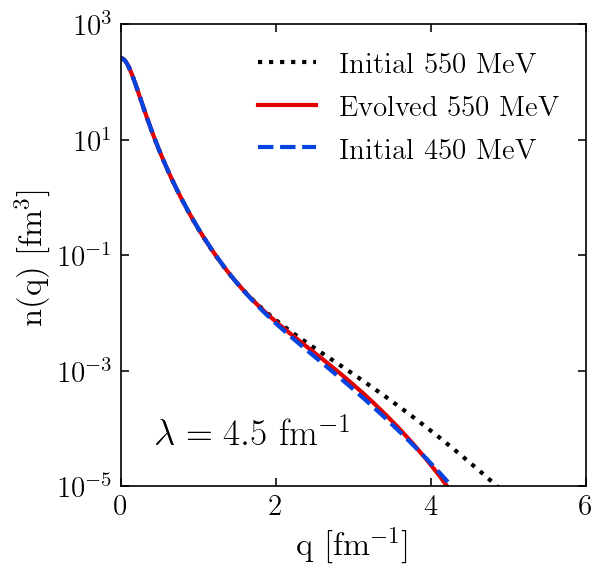

In [48]:
# Figure size
row_number = 1
col_number = 1
figure_size = (4*col_number, 4*row_number)

# Axes labels and fontsize
x_label = 'q [fm' + r'$^{-1}$' + ']'
x_label_size = 16
y_label = 'n(q) [fm' + r'$^3$' + ']'
y_label_size = 16

# Axes limits
xlim=(0, 6)
ylim=(1e-5, 1e3)

# Curve width
curve_width = 2.0

# Initialize figure
plt.close('all')
f, ax = plt.subplots(figsize=figure_size)
    
# Set y-axis to log scale
ax.set_yscale('log')

ax.plot(k_array, n_d_550MeV_init, label='Initial 550 MeV',
        linewidth=curve_width, linestyle='dotted', color='xkcd:black')
ax.plot(k_array, n_d_550MeV_srg, label='Evolved 550 MeV',
        linewidth=curve_width, color='xkcd:red')
ax.plot(k_array, n_d_450MeV_init, label='Initial 450 MeV',
        linewidth=curve_width, linestyle='dashed', color='xkcd:blue')
        
# Specify axes limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Set axes labels
ax.set_xlabel(x_label, fontsize=x_label_size)
ax.set_ylabel(y_label, fontsize=y_label_size)

# Set legend
legend_size = 14
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Add \lambda label
label = ff.lambda_label_conversion(lamb_match)
label_location = 'lower left'
label_size = 18
anchored_text = AnchoredText(label, loc=label_location,
                             prop=dict(size=label_size), frameon=False)
ax.add_artist(anchored_text);

In [49]:
def plot_levinger_ratio_test(nuclei, channels, kvnn, lamb_init, lamb_final,
                             kmax=15.0, kmid=3.0, ntot=120, edf='SLY4',
                             xlim=(0.0, 5.0), ylim=(0, 25)):

    # --- Set-up --- #
    
    # Set relative momentum values over [0, 5] fm^-1
    q_min, q_max, q_step = 0.0, 5.0, 0.05
    q_array = np.arange(q_min, q_max + q_step, q_step)
    ntot_q = len(q_array)
    
    # Set C.o.M. momentum array
    Q_max = 2.0 # Starts to get wonky at Q_max > 2.3 fm^-1
    ntot_Q = 40
    Q_array, Q_weights = gaussian_quadrature_mesh(Q_max, ntot_Q)
    
    # Set-up meshes corresponding to q_i and Q_j
    q_mesh, Q_mesh = np.meshgrid(q_array, Q_array, indexing='ij')
    
    # Set-up mesh for Q integration
    _, dQ_mesh = np.meshgrid(q_array, Q_array**2 * Q_weights, indexing='ij')
    factor = 4*np.pi/(2*np.pi)**3
    
    # Initialize deuteron momentum distribution class
    dmd = dmd_test(kvnn, lamb_init, lamb_final, kmax, kmid, ntot)
    
    R_array, _ = load_density('C12', 'proton', 6, 6)
    dR = R_array[2] - R_array[1] # Assuming linear spacing
    
    # Calculate deuteron momentum distribution
    n_d_array = dmd.n_total(q_array, R_array, dR)
    
    # Initialize pair momentum distribution class
    pmd = pmd_test(kvnn, channels, lamb_init, lamb_final, kmax, kmid, ntot)
    

    # --- Loop over nuclei and calculate ratio --- #
    
    # Store ratios in dictionary with nucleus name as key
    d = {}
    for nucleus in nuclei:
        
        # Details of the nucleus
        nucleus_name = nucleus[0]
        Z = nucleus[1]
        N = nucleus[2]
        A = N+Z
        
        R_array, rho_p_array = load_density(nucleus_name, 'proton', Z, N, edf)
        R_array, rho_n_array = load_density(nucleus_name, 'neutron', Z, N, edf)
        dR = R_array[2] - R_array[1]
        
        # Evaluate n(q, Q) at each point in relative and C.o.M. momentum
        n_pn_array_2d = 2*pmd.n_total(q_array, Q_array, R_array, dR,
                                      rho_p_array, rho_n_array) # 2 for pn+np

        # Integrate out Q dependence where
        # n(q) = 4\pi/(2\pi)^3 \int_0^\infty dQ Q^2 n(q, Q)
        n_pn_array = factor * np.sum(dQ_mesh * n_pn_array_2d, axis=-1)
    
        # Calculate ratio and store in dictionary
        ratio_array = A/(N*Z) * n_pn_array / n_d_array
        d[nucleus_name] = ratio_array

    # Set-up average value of L
    L_mean = 5.5
    L_sig = 0.21
    
    # Convert L +/- L_sigma to arrays for errorbands
    L_upper_array = np.ones(ntot_q) * (L_mean + L_sig)
    L_lower_array = np.ones(ntot_q) * (L_mean - L_sig)
    
    
    # --- Plot --- #
    
    # Figure size
    row_number = 1
    col_number = 1
    figure_size = (4*col_number, 4*row_number)

    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 16
    y_label = r'$\frac{A}{NZ} \frac{ n_{pn}^A(q) }{ n_{p}^d(q) }$'
    y_label_size = 16

    # Curve width
    curve_width = 2.0

    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)

    # Add Levinger constant to figure (L = 5.5 +/- 0.21)
    ax.axhline(y=L_mean, label='L', color='xkcd:black', linestyle='dotted')
    ax.fill_between(q_array, y1=L_lower_array, y2=L_upper_array,
                    color='xkcd:black', alpha=0.3)

    # Add ratios to plot
    for i, nucleus in enumerate(nuclei):
        
        # Name of nucleus (e.g., 'C12')
        nucleus_name = nucleus[0]
        ratio_array = d[nucleus_name]
        
        # Add nucleus to legend
        curve_label = ff.nuclei_label_conversion(nucleus_name)
        
        # Set color
        curve_color = ff.xkcd_colors(i+1) # Skip black
        
        ax.plot(q_array, ratio_array, label=curve_label, linewidth=curve_width,
                color=curve_color)
        
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    return f, ax

<ipython-input-45-8ee235ac81e8>:143: RuntimeWarning: divide by zero encountered in true_divide
  theta_mesh[case_3] = ( ( kF_mesh**2 - ( q_mesh - 2*k_mesh )**2 ) / \
<ipython-input-45-8ee235ac81e8>:149: RuntimeWarning: divide by zero encountered in true_divide
  theta_mesh[case_2] = ( ( kF_mesh**2 - ( q_mesh - 2*k_mesh )**2 ) / \
<ipython-input-46-21166c0b0256>:187: RuntimeWarning: divide by zero encountered in true_divide
  theta_mesh[case_2] = ( ( 2*(kF1_mesh**2+kF2_mesh**2) - 4*q_mesh**2 - \
<ipython-input-46-21166c0b0256>:192: RuntimeWarning: divide by zero encountered in true_divide
  ( -4 < (4*q_mesh**2-4*kF1_mesh**2+Q_mesh**2) / \
<ipython-input-46-21166c0b0256>:194: RuntimeWarning: divide by zero encountered in true_divide
  ( (4*q_mesh**2-4*kF1_mesh**2+Q_mesh**2) / \
<ipython-input-46-21166c0b0256>:196: RuntimeWarning: divide by zero encountered in true_divide
  theta_mesh[case_3] = ( ( 4*kF1_mesh**2 - (Q_mesh-2*q_mesh)**2 ) / \
<ipython-input-46-21166c0b0256>:201: RuntimeWarn

Done after 2.0 minutes.


Text(0.5, 1.0, 'RKE N$^4$LO 550 MeV, SLy4, $\\lambda=1.35$ fm$^{-1}$')

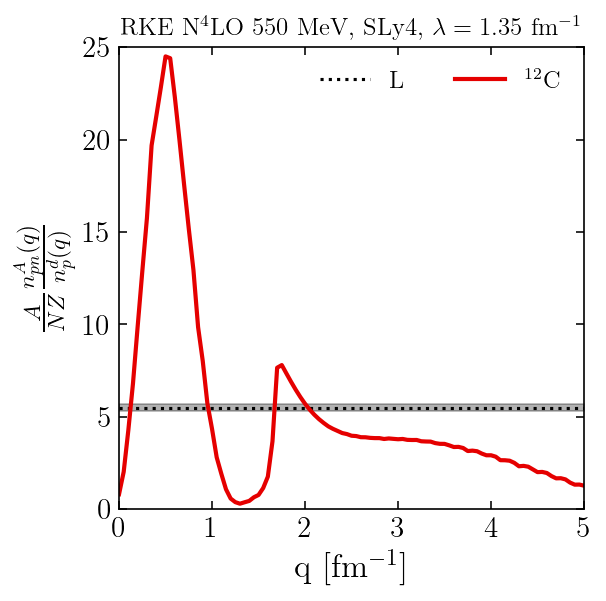

In [50]:
# Evolved RKE N4LO 550 MeV with SLy4 and S-waves only

nuclei_test = [ ('C12', 6, 6) ] # Test one nuclei (takes about )
kvnn = 113
lamb_init = 4.5 # This will roughly match the 450 MeV potential
lamb_final = 1.35
t0 = time.time()
f, ax = plot_levinger_ratio_test(nuclei_test, channels, kvnn, lamb_init, lamb_final,
                                 10.0, 2.0, ntot, edf)
t1 = time.time()
mins = (t1-t0)/60
print(f'Done after {mins:.2f} minutes.')

# Set legend
legend_size = 12
legend_location = 'upper right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size, ncol=2)

# Set title
kvnn_label = ff.kvnn_label_conversion(kvnn)
edf_label = 'SLy4'
lambda_label = ff.lambda_label_conversion(lamb)
title = f'{kvnn_label}, {edf_label}, {lambda_label}'
title_size = 12
ax.set_title(title, fontsize=title_size)

In [51]:
# Check contours for phenomenological potentials
def potential_contours(kvnn, channel, lambda_array, kmax=15.0, kmid=3.0,
                       ntot=120, axes_max=4.0, colorbar_limits=(-1.0, 1.0)):
    """
    Plots SRG-evolved NN potentials [fm] with respect to momentum [fm^-1].
    This is an 1 x n contour plot where n is the size of lambda_array.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1].
    kmax : float, optional
        Maximum value in the momentum mesh [fm^-1].
    kmid : float, optional
        Mid-point value in the momentum mesh [fm^-1].
    ntot : int, optional
        Number of momentum points in mesh.
    axes_max : float, optional
        Maximum value of momenta for xi and y-axis [fm^-1].
    colorbar_limits : tuple, optional
        Tuple specifying the minimum and maximum values [fm] of the colorbar.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # Load momentum
    k_array, _ = vnn.load_momentum(kvnn, channel, kmax, kmid, ntot)
    
    # Size of figure
    row_number = 1
    col_number = len(lambda_array)
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar
    
    # Axes limits
    axes_lim = (0.0, axes_max)
    
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    # Step-size in labeling tick marks
    if axes_max <= 5.0:
        axes_stepsize = 1.0
    elif 5.0 < axes_max <= 10.0:
        axes_stepsize = 2.0
    else:
        axes_stepsize = 3.0
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_ticks_strings = ff.convert_ticks_to_labels(axes_ticks)
    axes_tick_size = 16
    
    # Colorbar ticks, label, and fontsize
    mn = colorbar_limits[0]
    mx = colorbar_limits[1]
    levels_number = 61
    levels = np.linspace(mn, mx, levels_number)
    levels_ticks = np.linspace(mn, mx, 9)
    levels_ticks_strings = ff.convert_ticks_to_labels(levels_ticks)
    colorbar_label = '[fm]'
    colorbar_label_size = 18
    colorbar_tick_size = 18
    
    # Color scheme for contour plots
    color_style = 'turbo'
    

    # --- Load potentials --- #
    
    # Initialize dictionary to store evolved potentials
    d = {}
    
    # Loop over lambda values
    for lamb in lambda_array:
            
        # Load initial potential 
        V_matrix = vnn.load_potential(kvnn, channel, kmax, kmid, ntot, 'srg',
                                      'Wegner', lamb)
                
        # Interpolate the potential through 0 to axes_max for smoother
        # looking figure (the extension _int means interpolated)
        k_array_int, V_matrix_int = ff.interpolate_matrix(k_array, V_matrix,
                                                          axes_max + 0.2)
            
        # Store in dictionary with generator and lamb as keys
        d[lamb] = V_matrix_int
            
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True,
                          figsize=figure_size)
    
    # Loop over \lambda's keeping track of indices
    for i, lamb in enumerate(lambda_array):
            
        c = axs[i].contourf(k_array_int, k_array_int, d[lamb], levels,
                            cmap=color_style, extend='both')

        # Specify axes limits
        axs[i].set_xlim( axes_lim )
        axs[i].set_ylim( axes_lim )
                                         
        # Specify axes tick marks
        axs[i].xaxis.set_ticks(axes_ticks)
        axs[i].xaxis.set_ticklabels(axes_ticks_strings)
        # Switch from bottom to top
        axs[i].xaxis.set_label_position('top')
        axs[i].xaxis.tick_top()
        axs[i].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
        # Prevent overlapping x-axis tick marks
        if i < col_number - 1:
            xticks = axs[i].xaxis.get_major_ticks()
            xticks[-1].set_visible(False)

        # Set x-axis label
        axs[i].set_xlabel(x_label, fontsize=axes_label_size)
                                         
        # On the left column, set and label y-axis
        if i == 0:
                                         
            # Specify axes tick marks
            axs[i].yaxis.set_ticks(axes_ticks)
            axs[i].yaxis.set_ticklabels(axes_ticks_strings)
            axs[i].tick_params(labelsize=axes_tick_size)
                                         
            # Set y-axis label
            axs[i].set_ylabel(y_label, fontsize=axes_label_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    return f, axs

In [52]:
# # Check for the following \lambda values
# lambda_array = np.array( [6, 3, 2, 1.35] )

# # kvnn = 1 # Paris
# # kvnn = 2 # Bonn
# # kvnn = 3 # Reid93
# # kvnn = 4 # Nijmegen I
# # kvnn = 5 # Nijmegen II
# # kvnn = 6 # AV18
# # kvnn = 7 # CD-Bonn
# # kvnn = 111 # RKE N4LO 450 MeV
# kvnn = 113 # RKE N4LO 550 MeV

# # Set momentum mesh
# if kvnn < 10:
#     kmax, kmid, ntot = 15.0, 3.0, 120
# else:
#     kmax, kmid, ntot = 10.0, 2.0, 120

In [53]:
# # Check all of the new potentials in this cell

# # 1S0 channel
# channel = '1S0'

# axes_max = 5.0
# colorbar_lim = (-1, 1)

# f, axs = potential_contours(kvnn, channel, lambda_array, kmax, kmid, ntot,
#                             axes_max, colorbar_lim)

# # Add potential label to third sub-plot
# kvnn_label_size = 16
# kvnn_label_location = 'upper right'
# kvnn_label = ff.kvnn_label_conversion(kvnn)
# anchored_text = AnchoredText( kvnn_label, loc=kvnn_label_location,
#                               prop=dict(size=kvnn_label_size) )
# axs[-2].add_artist(anchored_text)

# # Add channel label to last sub-plot
# channel_label_size = 20
# channel_label_location = 'upper right'
# if channel == '1S0':
#     channel_label = ff.channel_label_conversion(channel)
# elif channel == '3S1':
#     channel_label = r'$^{3}{\rm S}_{1}-^{3}{\rm S}_{1}$'
# anchored_text = AnchoredText( channel_label, loc=channel_label_location,
#                               prop=dict(size=channel_label_size) )
# axs[-1].add_artist(anchored_text)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower left'
# for i, lamb in enumerate(lambda_array):
#     lambda_label = ff.lambda_label_conversion(lamb)
#     anchored_text = AnchoredText( lambda_label, loc=lambda_label_location,
#                                   prop=dict(size=lambda_label_size) )
#     axs[i].add_artist(anchored_text)

In [54]:
# # Check all of the new potentials in this cell

# # 3S1 channel
# channel = '3S1'

# axes_max = 5.0
# colorbar_lim = (-1, 1)

# f, axs = potential_contours(kvnn, channel, lambda_array, kmax, kmid, ntot,
#                             axes_max, colorbar_lim)

# # Add potential label to third sub-plot
# kvnn_label_size = 16
# kvnn_label_location = 'upper right'
# kvnn_label = ff.kvnn_label_conversion(kvnn)
# anchored_text = AnchoredText( kvnn_label, loc=kvnn_label_location,
#                               prop=dict(size=kvnn_label_size) )
# axs[-2].add_artist(anchored_text)

# # Add channel label to last sub-plot
# channel_label_size = 20
# channel_label_location = 'upper right'
# if channel == '1S0':
#     channel_label = ff.channel_label_conversion(channel)
# elif channel == '3S1':
#     channel_label = r'$^{3}{\rm S}_{1}-^{3}{\rm S}_{1}$'
# anchored_text = AnchoredText( channel_label, loc=channel_label_location,
#                               prop=dict(size=channel_label_size) )
# axs[-1].add_artist(anchored_text)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower left'
# for i, lamb in enumerate(lambda_array):
#     lambda_label = ff.lambda_label_conversion(lamb)
#     anchored_text = AnchoredText( lambda_label, loc=lambda_label_location,
#                                   prop=dict(size=lambda_label_size) )
#     axs[i].add_artist(anchored_text)